In [133]:
%matplotlib inline
import glob
import numpy as np
import random
import pandas as pd
import seaborn as sns; sns.set()
import os
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt

from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker 
from nilearn import plotting,image, glm
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.connectome import ConnectivityMeasure

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import permutation_test_score
from pathlib import Path

from nltools.stats import fdr, norm

from sklearn.metrics import confusion_matrix

import joblib
import numpy as np
from pathlib import Path

# pour enlever les warnings
import warnings
warnings.filterwarnings('ignore')

# Import data

In [134]:
# load dataset containing sex and participant id
df = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/Final_HCP_database.csv")
df

,Unnamed: 0,index,subject_label,Release,Acquisition,Gender,Age_in_Yrs,Race,Ethnicity,Handedness,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,0,0,100206,S900,Q11,0,27,White,Not Hispanic/Latino,65,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
1,1,1,100610,S900,Q08,0,27,White,Not Hispanic/Latino,85,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
2,2,2,101006,S500,Q06,1,35,Black or African Am.,Not Hispanic/Latino,90,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
3,3,4,102008,S500,Q06,0,24,White,Hispanic/Latino,80,...,6.0,122.25,110.45,0.0,50.1,67.48,65.31,1.80,0.0,1.80
4,4,7,102513,S900,Q10,0,30,White,Not Hispanic/Latino,50,...,5.2,108.79,98.04,2.0,54.3,84.07,82.37,1.92,0.0,1.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,559,662,990366,S900,Q10,0,22,White,Not Hispanic/Latino,95,...,4.4,108.79,97.19,1.0,52.6,93.82,92.63,1.80,0.0,1.80
560,560,663,991267,S500,Q06,0,30,White,Not Hispanic/Latino,75,...,2.8,122.25,111.41,1.0,46.6,83.23,81.55,1.84,0.0,1.84
561,561,664,992673,S900,Q12,1,33,White,Not Hispanic/Latino,70,...,3.6,122.25,111.41,1.0,38.6,101.63,99.26,1.80,0.0,1.80
562,562,665,993675,S900,Q09,1,29,White,Not Hispanic/Latino,85,...,0.4,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76


In [136]:
# get the faster seed
file_path = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_2024/seed-{seed_name}_atlas-destrieux_mean-all4_gmcorrected__voxelcorrelations.csv"
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
data = {}

for seed in SEEDS:
    file = file_path.format(seed_name=seed)
    loaded = pd.read_csv(file_path.format(seed_name=seed))
    for subject in df["subject_label"]:
        string = "sub-"+str(subject)
        new  = loaded.loc[loaded["Unnamed: 0"] == string]
        data[(subject, seed)] = new.loc[:, new.columns!='Unnamed: 0'].to_numpy()[0]

In [137]:
df_boot = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/Final_HCP_database.csv")
x_correl = []
for sub in tqdm(df_boot["subject_label"]):
    line_temp = []
    for seed in SEEDS:
        line_temp.append(data[(sub, seed)])
    x_correl.append(np.concatenate(line_temp))
x_correl = np.array(x_correl)


100%|█████████████████████████████████████| 564/564 [00:00<00:00, 130601.64it/s]


# Define function

In [138]:
def regionsOfInterest(accuracy, pvalue, moyenne, rois, label, x_correl):
    pvalue_val = pvalue.reshape(len(rois), 148).T
    pvalue_uncorrected = pvalue_val < 0.05

    data_pval_uncorrected = pd.DataFrame(pvalue_uncorrected, columns=rois)
    data_pval = pd.DataFrame(pvalue_val, columns=rois)

    pval_corrected = np.multiply(pvalue_val, pvalue_uncorrected)
    
    X_std = x_correl.std()
    weighted_coef = moyenne * X_std
    label_name = list(label['name']) * len(rois)
    seed_name = np.repeat(rois, 148)

    # X_std = x_correl.std()
    # weighted_coef = moyenne * X_std
    # label_name = list(label['name']) * len(rois)
    # seed_name = np.repeat(rois, 148)
    
    weighted_tab = pd.DataFrame(weighted_coef, columns=["coefficient"])
    weighted_tab['seed'] = seed_name
    weighted_tab['labels'] = label_name
    
    # print the 10 best seed anf their labels
    print(weighted_tab.sort_values(by=['coefficient'], ascending=False).head(10))
    
    
    # weighted_coef[weighted_coef<0.054609] = 0 # maybe changed the 0.054609 for a variable
        
    
    # printing the accuracy and its interval of confidance
    acc_test = np.asarray(accuracy)
    moy = np.mean(acc_test)
    se = np.std(acc_test)
    lower = moy - (1.96 * se)
    upper = moy + (1.96 * se)
    
    print("The mean accuracy : " + str(moy))
    print("The standard deviation of the accuracy : " + str(se))
    print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
    print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
    
    return weighted_tab

In [139]:
def bestRegion(ROIs, data_dict, data_df):
    
    best = ROIs.sort_values(by=['coefficient'], ascending=False).head(10)
    best_roi = []

    for row in best.iterrows():
        best_roi.append([row[1][1], row[1][2], [], []])

    label_female = []
    label_male = []

    for i in range(0,len(data_df["Gender"])):
        if data_df["Gender"][i] == 0:
            label_male.append(data_df["subject_label"][i])

        elif data_df["Gender"][i] == 1:
            label_female.append(data_df["subject_label"][i])
            

    for i in data_dict.keys():
        if label_male.count(i[0]) > 0:
            for j in range(0, len(best_roi)):
                if (best_roi[j][0] == i[1]):
                    best_roi[j][2].append(data_dict[i[0], best_roi[j][0]][label[label["name"] == best_roi[j][1]].index.values[0]])

        elif label_female.count(i[0]) > 0:
            for j in range(0, len(best_roi)):
                if (best_roi[j][0] == i[1]):
                    best_roi[j][3].append(data_dict[i[0], best_roi[j][0]][label[label["name"] == best_roi[j][1]].index.values[0]])

    table_best = pd.DataFrame(columns=["Region", "Men", "Women", "P value"])
    for i in range(0, len(best_roi)):
        best_roi[i][2] = np.asarray(best_roi[i][2]) # male
        best_roi[i][3] = np.asarray(best_roi[i][3]) # female
        plt.boxplot([best_roi[i][2], best_roi[i][3]])
        plt.xticks([1,2], ["male", "female"])
        plt.title(best_roi[i][0]+" "+best_roi[i][1])
        plt.show()
        print(stats.ttest_ind(best_roi[i][2], best_roi[i][3]))
        print("male mean : "+ str(np.mean(best_roi[i][2])))
        print("female mean : "+ str(np.mean(best_roi[i][3])))
        table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],
                                        'Men' : np.mean(best_roi[i][2]), 
                                        'Women' : np.mean(best_roi[i][3]), 
                                        'P value' : stats.ttest_ind(best_roi[i][2], best_roi[i][3])[1]}, ignore_index=True)
        
    print(table_best)

In [140]:
def bootstrap_scores(boot_coefs):
    """
    Calculate z scores and p-value based on bootstrap coefficients
    
    Parameters
    ----------
    boot_coefs: bootstrap coefficients (array-like)
    
    Returns
    ----------
    z_scores: z scores calculated from bootstrap coefficients
    pval: p-value calculated from z-scores
    pval_bonf: corrected p-values using bonferonni correction
    
    See also nltools summarized_bootstrap function: https://nltools.org/_modules/nltools/stats.html
    """
    mean_scores = np.mean(boot_coefs, axis=0)
    z_scores = np.mean(boot_coefs, axis=0)/np.std(boot_coefs, axis=0)
    assert np.sum(np.isnan(z_scores)) == 0
    pval = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))
    pval_bonf = np.where(pval < (0.05/len(pval)), pval, 0)
    #boot_z_fdr = np.where(pval < fdr(pval, q=0.05), pval, 0)
    
    return mean_scores, z_scores, pval, pval_bonf#, boot_z_fdr

In [141]:
def compute_results(results_path):
    results = joblib.load(results_path)

    coefs = []
    for result in results:
        coefs.append(result["model"].coef_[0])

    coefs = np.array(coefs)

    data_results = pd.DataFrame.from_dict(results)
    moyenne, scoresZ, pvalue, pvalue_bonf = bootstrap_scores(coefs)
    return moyenne, scoresZ, pvalue_bonf, data_results

## Define data path to each model results

In [142]:
study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/')
results_path_all_seed = study_dir / "results_2024" / "LinearSVC" / "seed-all_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_aMTG_L = study_dir / "results_2024" / "LinearSVC" / "seed-aMTG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_aMTG_R = study_dir / "results_2024" / "LinearSVC" / "seed-aMTG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_opIFG_L = study_dir / "results_2024" / "LinearSVC" / "seed-opIFG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_opIFG_R = study_dir / "results_2024" / "LinearSVC" / "seed-opIFG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_pITG_L = study_dir / "results_2024" / "LinearSVC" / "seed-pITG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_pITG_R = study_dir / "results_2024" / "LinearSVC" / "seed-pITG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_planumtemp_L = study_dir / "results_2024" / "LinearSVC" / "seed-planumtemp_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_planumtemp_R = study_dir / "results_2024" / "LinearSVC" / "seed-planumtemp_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_all_left = study_dir / "results_2024" / "LinearSVC" / "seed-left_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_all_right = study_dir / "results_2024" / "LinearSVC" / "seed-right_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"


# Best region with grey matter corrected

In [143]:
# fetching label from destrieux atlas minus two labels not used
atlas_dest = datasets.fetch_atlas_destrieux_2009(legacy_format=False)
label = atlas_dest["labels"].drop([0,42,117]) # correction for the destrieux atlas labels
label = label.reset_index()

In [144]:
# mean confusion matrix
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion.mean()

predicted class,Femme,Homme
actual class,,
Femme,55.2085,5.1361
Homme,5.4575,47.1979


## Best regions all seed

      coefficient          seed                       labels
98       0.080936       opIFG_L       R G_pariet_inf-Angular
1079     0.061961        pITG_R                L S_calcarine
55       0.061655       opIFG_L  L S_intrapariet_and_P_trans
53       0.059059       opIFG_L                L S_front_sup
379      0.057851        aMTG_L      R G_cingul-Post-ventral
301      0.055354        aMTG_L         L G_and_S_cingul-Ant
504      0.053628        pITG_L  L S_oc-temp_med_and_Lingual
305      0.053026        aMTG_L      L G_cingul-Post-ventral
189      0.052916  planumtemp_L             L Pole_occipital
1013     0.051722        aMTG_R                R S_front_inf
The mean accuracy : 0.9062513274336282
The standard deviation of the accuracy : 0.02943331307469047
The lower boundry of the confidance interval of the accuracy : 0.8485620338072349
The upper boundry of the confidance interval of the accuracy : 0.9639406210600215


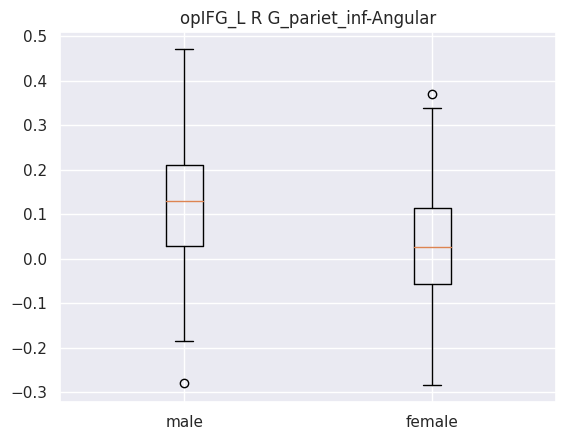

Ttest_indResult(statistic=7.716695110055561, pvalue=5.480751648776057e-14)
male mean : 0.11766997985152092
female mean : 0.03601953544850498


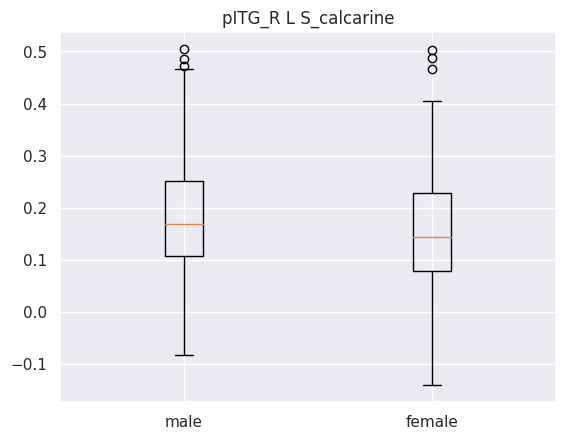

Ttest_indResult(statistic=3.2351347094550422, pvalue=0.0012873143650390924)
male mean : 0.18480961091102663
female mean : 0.1554359898385382


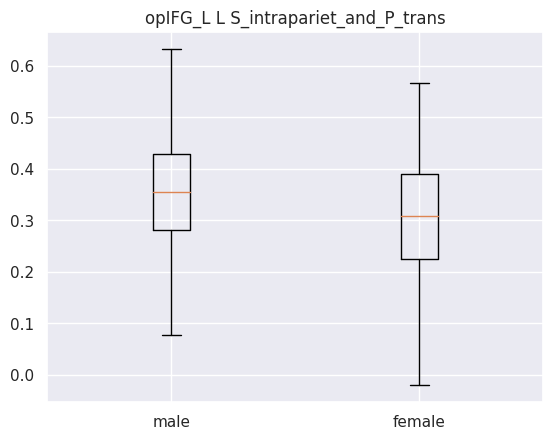

Ttest_indResult(statistic=5.055350828931209, pvalue=5.821781911163281e-07)
male mean : 0.35213074777946773
female mean : 0.3031099729109635


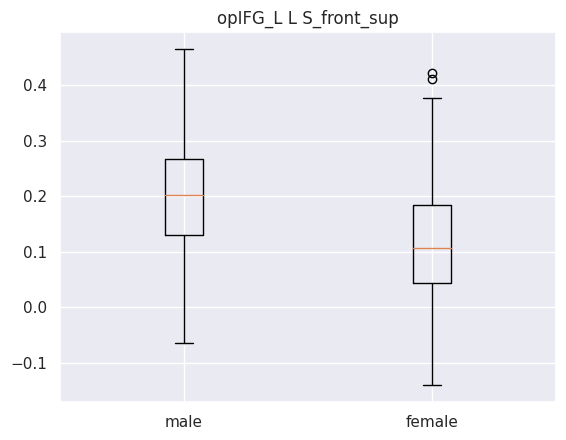

Ttest_indResult(statistic=10.006029115486237, pvalue=8.422510097736992e-22)
male mean : 0.1996858131581749
female mean : 0.11606861896099667


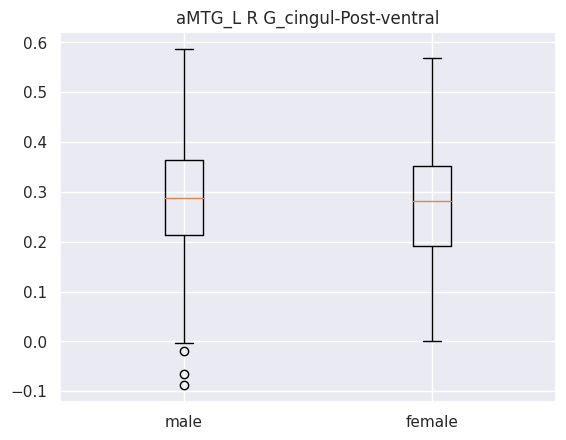

Ttest_indResult(statistic=0.6388341521167346, pvalue=0.5231910904943788)
male mean : 0.2817180546878327
female mean : 0.27555022588073086


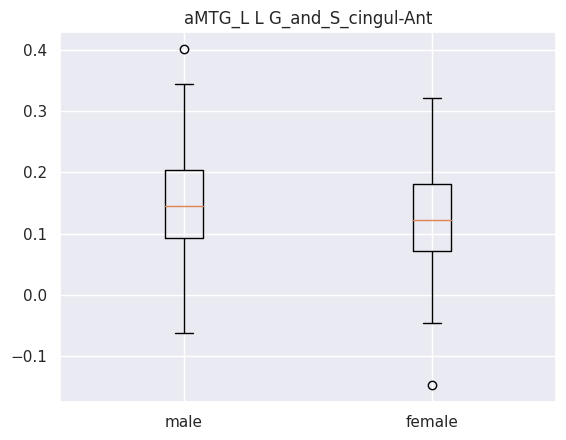

Ttest_indResult(statistic=3.7303929972815153, pvalue=0.0002105917212726882)
male mean : 0.15045088956692015
female mean : 0.1251106278551495


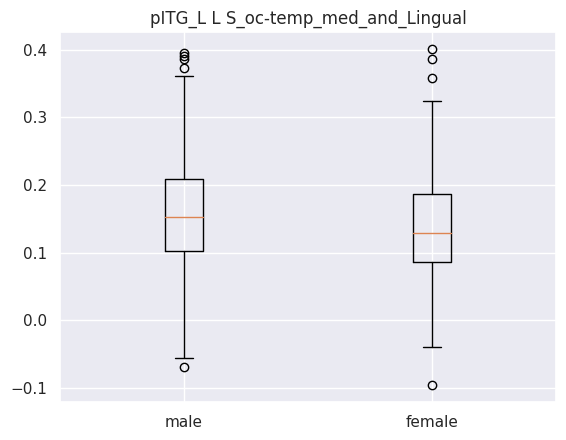

Ttest_indResult(statistic=3.01993636806222, pvalue=0.002643129220462383)
male mean : 0.1601642877536882
female mean : 0.13959590949933556


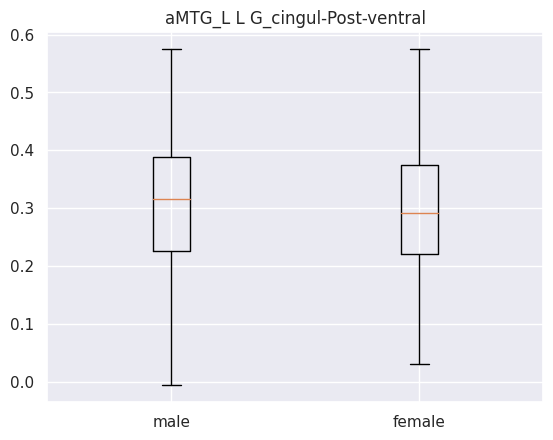

Ttest_indResult(statistic=1.3702197065710244, pvalue=0.17116542321143072)
male mean : 0.3069893446501901
female mean : 0.29388020735880394


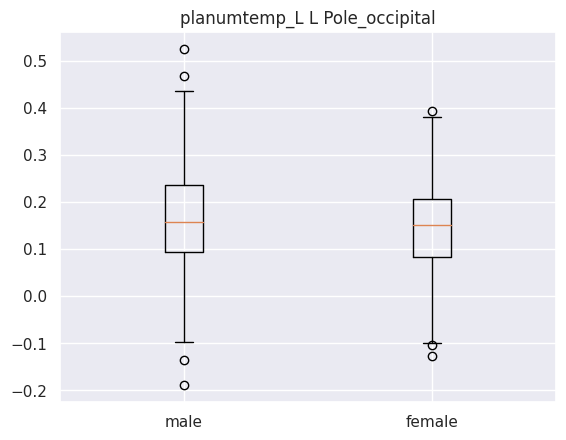

Ttest_indResult(statistic=2.486200541931443, pvalue=0.013200894125973316)
male mean : 0.16626784924790874
female mean : 0.14439602449857145


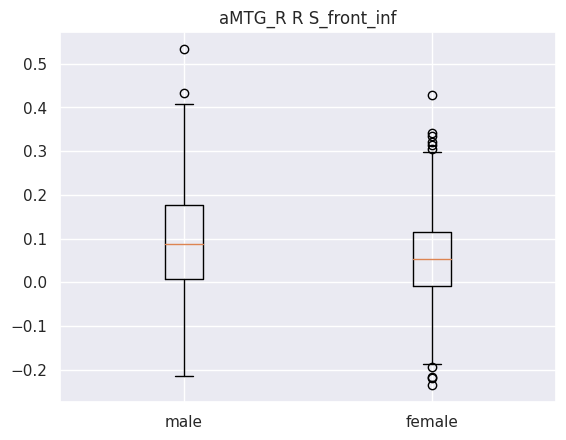

Ttest_indResult(statistic=4.148252422200393, pvalue=3.868639529214971e-05)
male mean : 0.09520096379193917
female mean : 0.055367278695980064
                                  Region       Men     Women       P value
0       opIFG_L - R G_pariet_inf-Angular  0.117670  0.036020  5.480752e-14
1                 pITG_R - L S_calcarine  0.184810  0.155436  1.287314e-03
2  opIFG_L - L S_intrapariet_and_P_trans  0.352131  0.303110  5.821782e-07
3                opIFG_L - L S_front_sup  0.199686  0.116069  8.422510e-22
4       aMTG_L - R G_cingul-Post-ventral  0.281718  0.275550  5.231911e-01
5          aMTG_L - L G_and_S_cingul-Ant  0.150451  0.125111  2.105917e-04
6   pITG_L - L S_oc-temp_med_and_Lingual  0.160164  0.139596  2.643129e-03
7       aMTG_L - L G_cingul-Post-ventral  0.306989  0.293880  1.711654e-01
8        planumtemp_L - L Pole_occipital  0.166268  0.144396  1.320089e-02
9                 aMTG_R - R S_front_inf  0.095201  0.055367  3.868640e-05


In [145]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_seed)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions for aMTG_L

     coefficient    seed                       labels
22      0.251448  aMTG_L      L G_oc-temp_med-Parahip
98      0.235516  aMTG_L       R G_pariet_inf-Angular
104     0.216673  aMTG_L                   R G_rectus
64      0.198969  aMTG_L        L S_parieto_occipital
53      0.187694  aMTG_L                L S_front_sup
131     0.179025  aMTG_L   R S_oc_sup_and_transversal
55      0.177971  aMTG_L  L S_intrapariet_and_P_trans
29      0.154544  aMTG_L                L G_precuneus
87      0.154097  aMTG_L       R G_front_inf-Triangul
103     0.137369  aMTG_L                R G_precuneus
The mean accuracy : 0.8101433628318584
The standard deviation of the accuracy : 0.03814689567474887
The lower boundry of the confidance interval of the accuracy : 0.7353754473093506
The upper boundry of the confidance interval of the accuracy : 0.8849112783543662


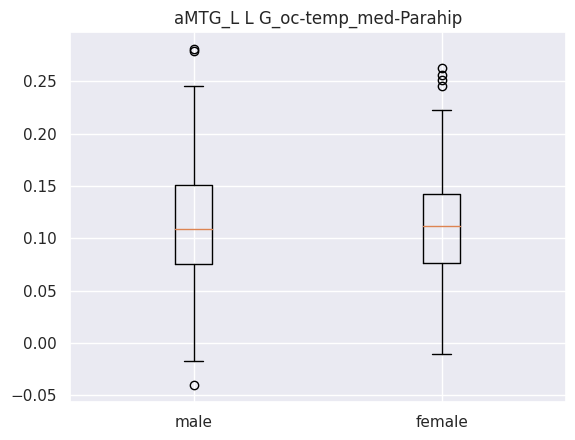

Ttest_indResult(statistic=1.1334696103846564, pvalue=0.25750038435672185)
male mean : 0.11530491022243346
female mean : 0.11041756162126246


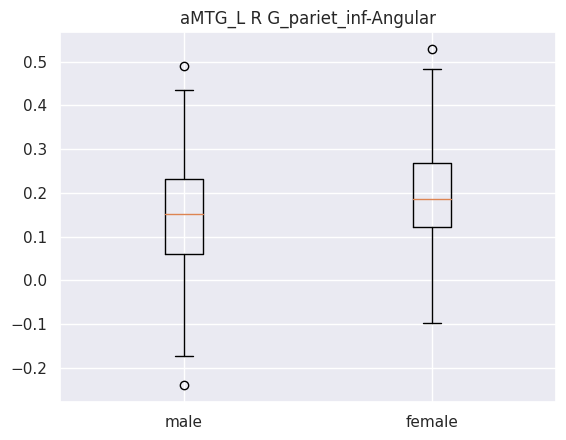

Ttest_indResult(statistic=-4.609075888150725, pvalue=5.010077069107832e-06)
male mean : 0.1466265599053232
female mean : 0.1927383331056479


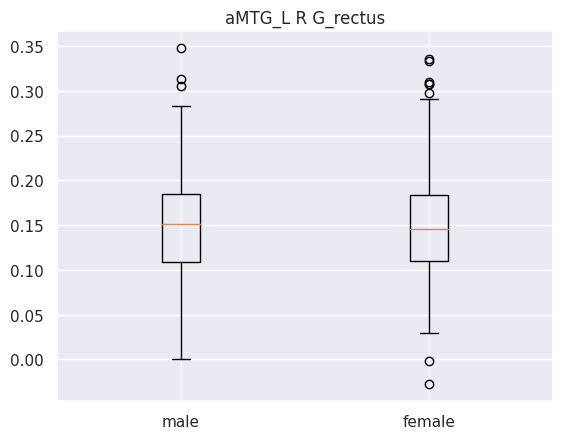

Ttest_indResult(statistic=-0.050680278730783346, pvalue=0.9595982987735558)
male mean : 0.14921290738174903
female mean : 0.14947103351827243


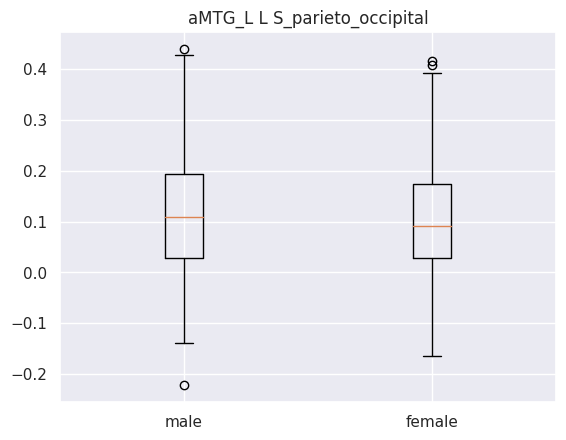

Ttest_indResult(statistic=0.8844937044320892, pvalue=0.3768080010830589)
male mean : 0.11133875940456274
female mean : 0.10330131695813953


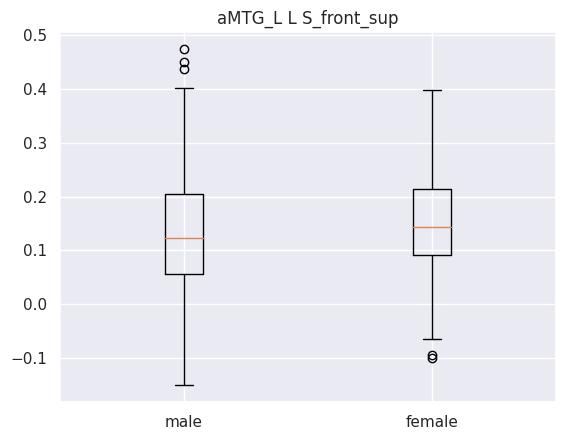

Ttest_indResult(statistic=-1.4354160996967782, pvalue=0.15172486392697015)
male mean : 0.13497622929505704
female mean : 0.14753736321687708


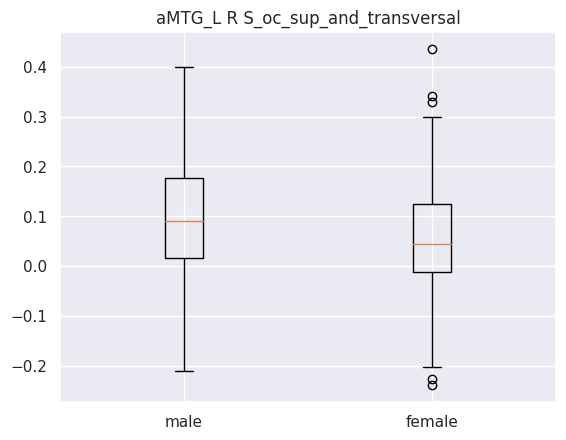

Ttest_indResult(statistic=4.340453076267227, pvalue=1.686421726368641e-05)
male mean : 0.09461966041634981
female mean : 0.054491475181651164


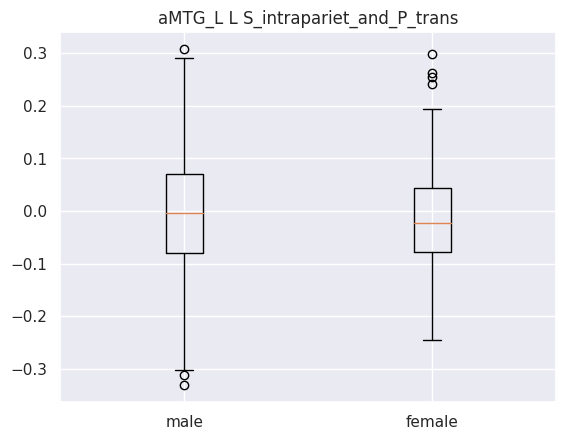

Ttest_indResult(statistic=0.9647641183387371, pvalue=0.3350779189775276)
male mean : -0.004121455086692014
female mean : -0.012516677279534883


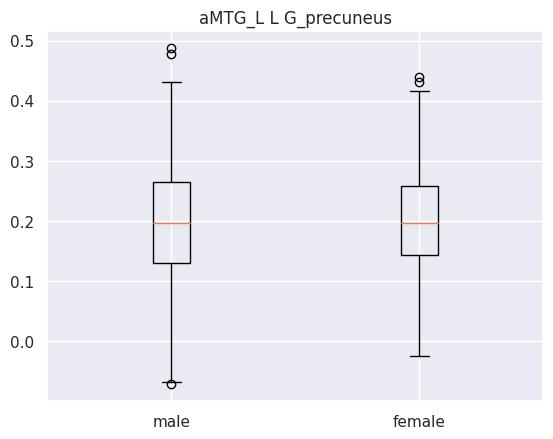

Ttest_indResult(statistic=0.34352085134667926, pvalue=0.7313351295320519)
male mean : 0.2003016257026616
female mean : 0.1975837047968771


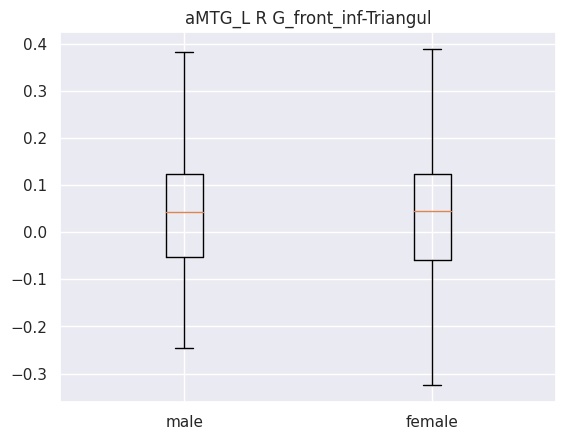

Ttest_indResult(statistic=0.12631199818411354, pvalue=0.8995301343742685)
male mean : 0.04378524430243346
female mean : 0.042384303678737544


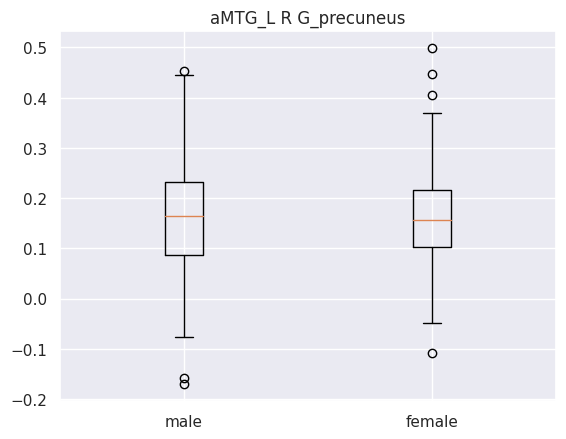

Ttest_indResult(statistic=-0.3353892597148926, pvalue=0.7374566259309934)
male mean : 0.15796897781863115
female mean : 0.16072608648106312
                                 Region       Men     Women   P value
0      aMTG_L - L G_oc-temp_med-Parahip  0.115305  0.110418  0.257500
1       aMTG_L - R G_pariet_inf-Angular  0.146627  0.192738  0.000005
2                   aMTG_L - R G_rectus  0.149213  0.149471  0.959598
3        aMTG_L - L S_parieto_occipital  0.111339  0.103301  0.376808
4                aMTG_L - L S_front_sup  0.134976  0.147537  0.151725
5   aMTG_L - R S_oc_sup_and_transversal  0.094620  0.054491  0.000017
6  aMTG_L - L S_intrapariet_and_P_trans -0.004121 -0.012517  0.335078
7                aMTG_L - L G_precuneus  0.200302  0.197584  0.731335
8       aMTG_L - R G_front_inf-Triangul  0.043785  0.042384  0.899530
9                aMTG_L - R G_precuneus  0.157969  0.160726  0.737457


In [146]:
rois = ["aMTG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_aMTG_L)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions aMTG_R

     coefficient    seed                       labels
22      0.244687  aMTG_R      L G_oc-temp_med-Parahip
90      0.223095  aMTG_R    R G_Ins_lg_and_S_cent_ins
98      0.192974  aMTG_R       R G_pariet_inf-Angular
104     0.180849  aMTG_R                   R G_rectus
66      0.164490  aMTG_R              L S_postcentral
75      0.163681  aMTG_R      R G_and_S_occipital_inf
55      0.163259  aMTG_R  L S_intrapariet_and_P_trans
108     0.152673  aMTG_R      R G_temp_sup-Plan_polar
4       0.142937  aMTG_R   L G_and_S_transv_frontopol
135     0.142490  aMTG_R          R S_orbital_lateral
The mean accuracy : 0.8038442477876107
The standard deviation of the accuracy : 0.039244147490102514
The lower boundry of the confidance interval of the accuracy : 0.7269257187070097
The upper boundry of the confidance interval of the accuracy : 0.8807627768682116


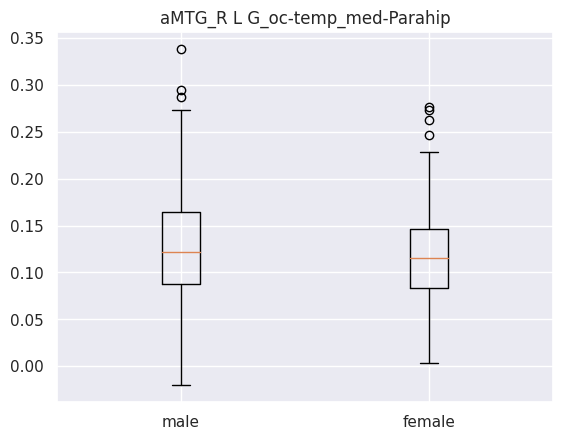

Ttest_indResult(statistic=2.0619605458315986, pvalue=0.039670656140978776)
male mean : 0.1272253816121673
female mean : 0.11806232951096346


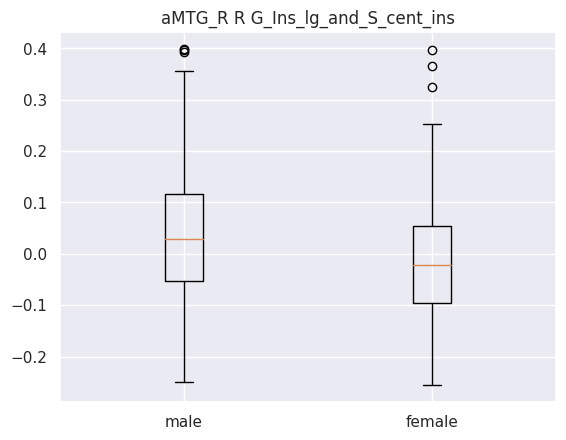

Ttest_indResult(statistic=4.892230628154193, pvalue=1.3038463843832238e-06)
male mean : 0.03623579969863118
female mean : -0.012065202055481731


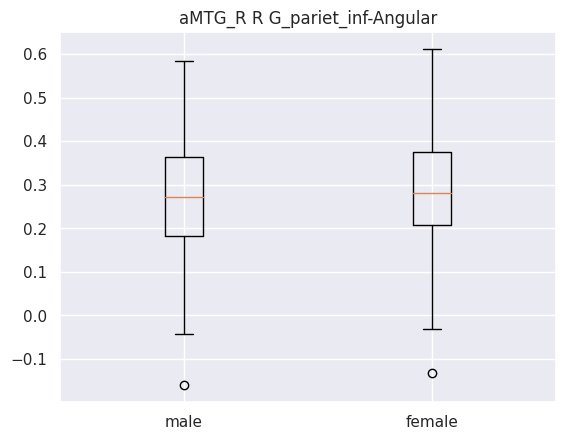

Ttest_indResult(statistic=-1.3474458962609632, pvalue=0.17837963763879625)
male mean : 0.2745868511307985
female mean : 0.2885656095314618


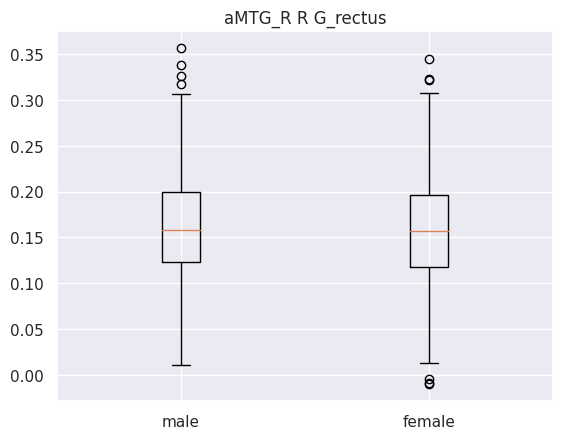

Ttest_indResult(statistic=0.25672681729231484, pvalue=0.7974836233347031)
male mean : 0.1602442236539924
female mean : 0.1588885866717608


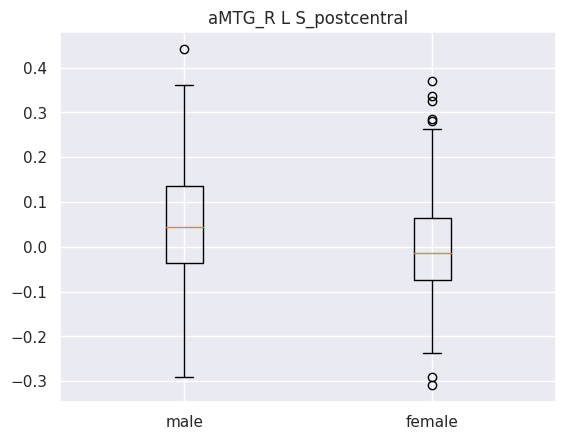

Ttest_indResult(statistic=4.256925055374874, pvalue=2.4287280099892244e-05)
male mean : 0.04534421238403042
female mean : 0.000728705031428572


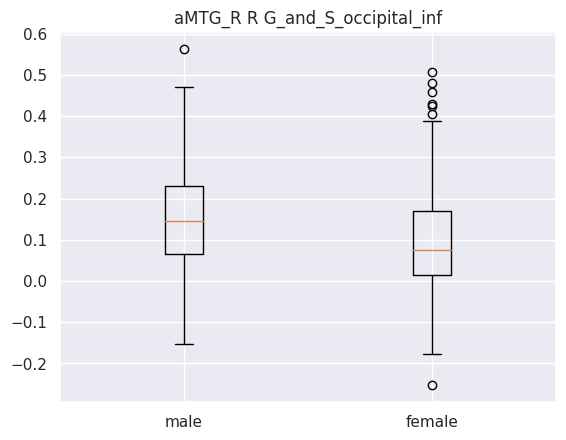

Ttest_indResult(statistic=5.746838754084861, pvalue=1.4919371944492937e-08)
male mean : 0.1548778395163498
female mean : 0.09606502119933555


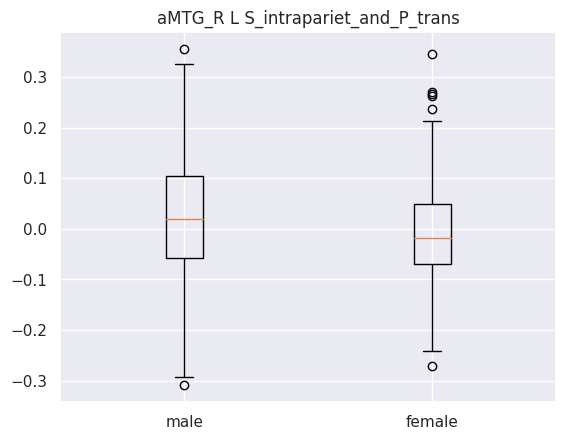

Ttest_indResult(statistic=3.0510209113028184, pvalue=0.0023882691927384963)
male mean : 0.018445383925361214
female mean : -0.008577846181096346


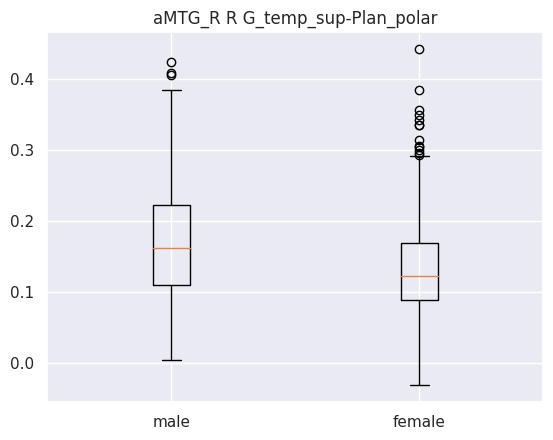

Ttest_indResult(statistic=5.308541697972609, pvalue=1.593449987883036e-07)
male mean : 0.17148337507528516
female mean : 0.136273162079402


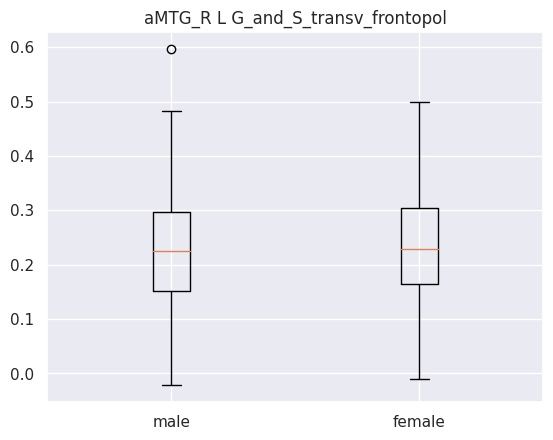

Ttest_indResult(statistic=-0.2621748360542157, pvalue=0.793282720636715)
male mean : 0.22834782620342206
female mean : 0.23062295921428572


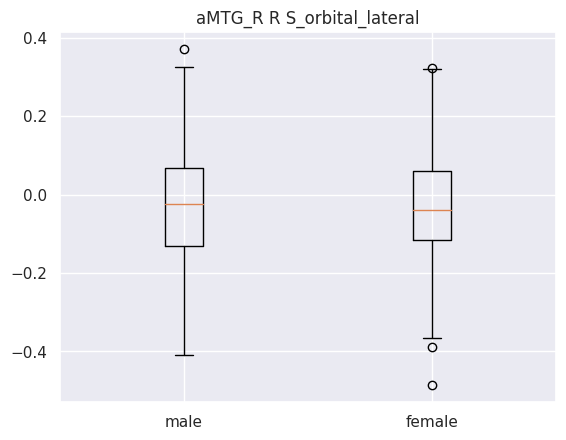

Ttest_indResult(statistic=0.3799477655046024, pvalue=0.7041277300292638)
male mean : -0.02739585445323194
female mean : -0.0318923487744186
                                 Region       Men     Women       P value
0      aMTG_R - L G_oc-temp_med-Parahip  0.127225  0.118062  3.967066e-02
1    aMTG_R - R G_Ins_lg_and_S_cent_ins  0.036236 -0.012065  1.303846e-06
2       aMTG_R - R G_pariet_inf-Angular  0.274587  0.288566  1.783796e-01
3                   aMTG_R - R G_rectus  0.160244  0.158889  7.974836e-01
4              aMTG_R - L S_postcentral  0.045344  0.000729  2.428728e-05
5      aMTG_R - R G_and_S_occipital_inf  0.154878  0.096065  1.491937e-08
6  aMTG_R - L S_intrapariet_and_P_trans  0.018445 -0.008578  2.388269e-03
7      aMTG_R - R G_temp_sup-Plan_polar  0.171483  0.136273  1.593450e-07
8   aMTG_R - L G_and_S_transv_frontopol  0.228348  0.230623  7.932827e-01
9          aMTG_R - R S_orbital_lateral -0.027396 -0.031892  7.041277e-01


In [147]:
rois = ["aMTG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_aMTG_R)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions opIFG_L

     coefficient     seed                       labels
20      0.189302  opIFG_L      L G_oc-temp_lat-fusifor
47      0.182472  opIFG_L      L S_circular_insula_inf
72      0.177692  opIFG_L             L S_temporal_sup
60      0.171919  opIFG_L  L S_oc-temp_med_and_Lingual
91      0.170919  opIFG_L            R G_insular_short
144     0.170130  opIFG_L              R S_subparietal
40      0.164383  opIFG_L               L Lat_Fis-post
1       0.151775  opIFG_L      L G_and_S_occipital_inf
89      0.148907  opIFG_L                R G_front_sup
64      0.134829  opIFG_L        L S_parieto_occipital
The mean accuracy : 0.8340097345132743
The standard deviation of the accuracy : 0.036209078636102635
The lower boundry of the confidance interval of the accuracy : 0.7630399403865131
The upper boundry of the confidance interval of the accuracy : 0.9049795286400355


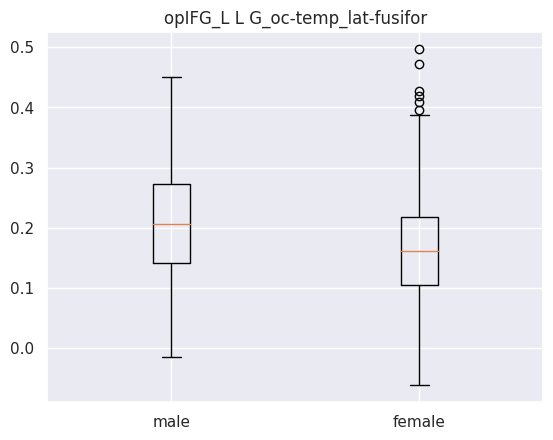

Ttest_indResult(statistic=5.698927511987025, pvalue=1.9476660856975242e-08)
male mean : 0.21165041260456274
female mean : 0.1668287685760797


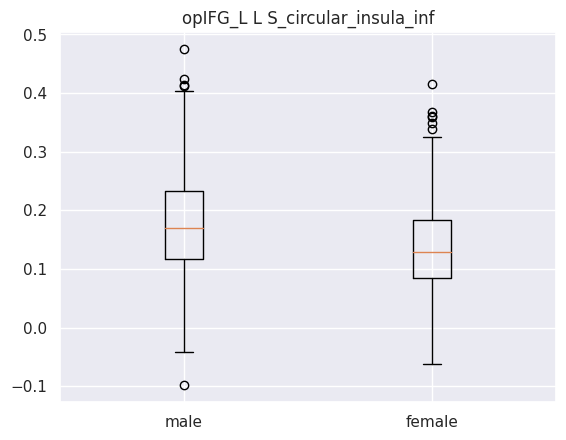

Ttest_indResult(statistic=5.793990901906812, pvalue=1.1455922176287184e-08)
male mean : 0.17968730860456272
female mean : 0.13831419359568106


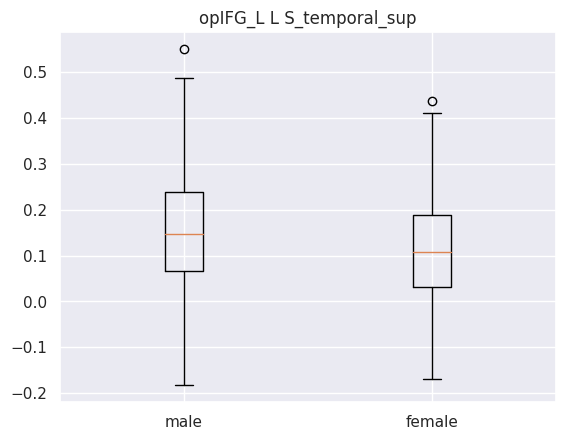

Ttest_indResult(statistic=4.104919666823164, pvalue=4.644482275203613e-05)
male mean : 0.15756035950874525
female mean : 0.11516167434405318


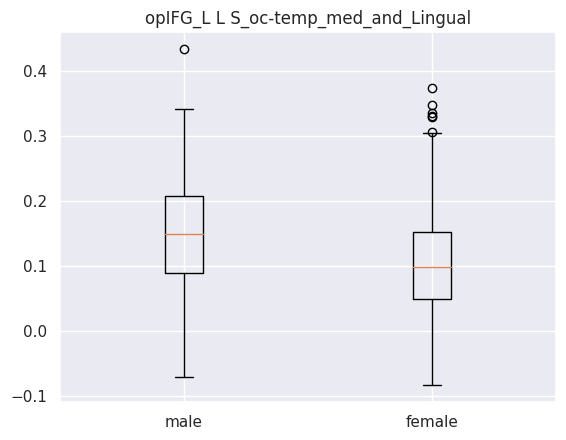

Ttest_indResult(statistic=5.979839353972038, pvalue=3.974325533230207e-09)
male mean : 0.1488611000961977
female mean : 0.10701805680602991


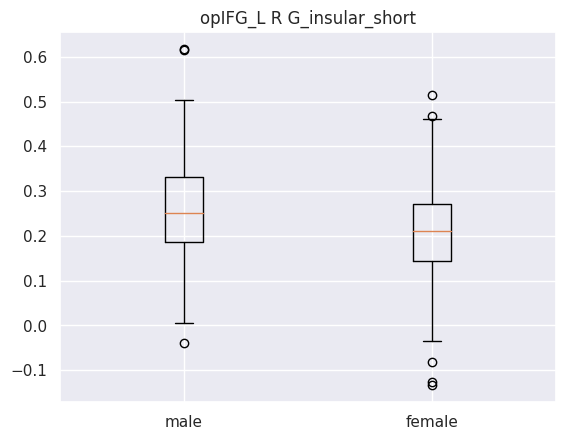

Ttest_indResult(statistic=5.4808703280162065, pvalue=6.398857490240382e-08)
male mean : 0.25729847525475286
female mean : 0.20946871466478406


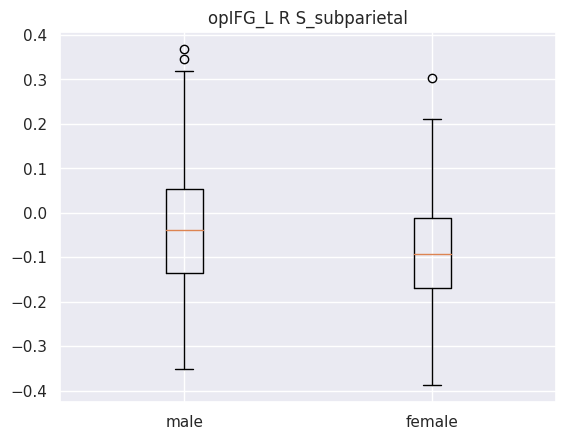

Ttest_indResult(statistic=4.627538320714266, pvalue=4.59863706792552e-06)
male mean : -0.0332647789439924
female mean : -0.08209271020398672


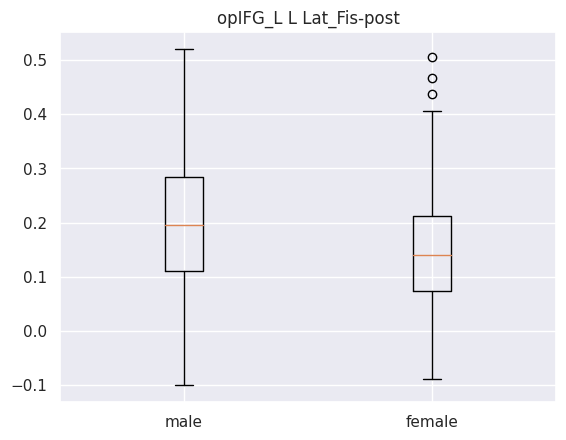

Ttest_indResult(statistic=5.935387024296681, pvalue=5.1325420089517246e-09)
male mean : 0.2050836814703422
female mean : 0.15007587232843853


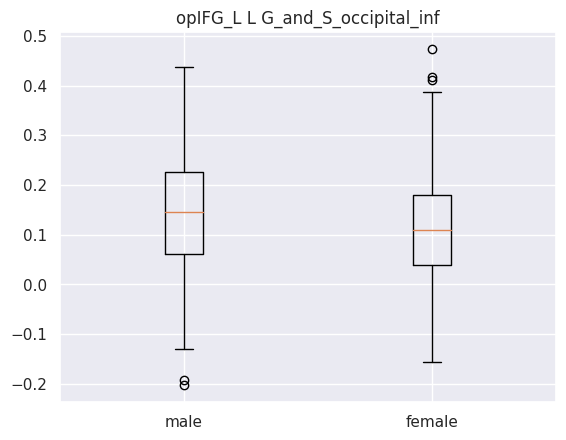

Ttest_indResult(statistic=3.3566638640413826, pvalue=0.000842207438429869)
male mean : 0.14831989778022814
female mean : 0.11545700281893687


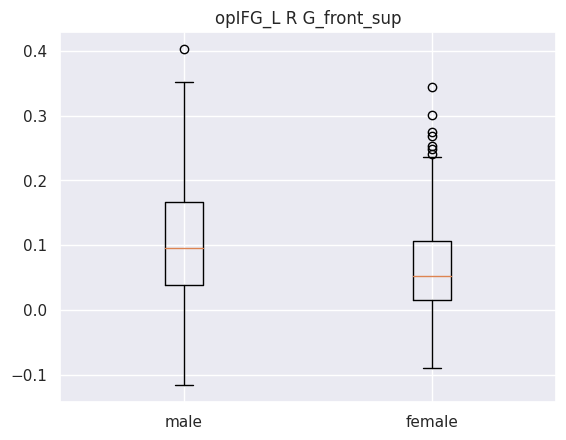

Ttest_indResult(statistic=5.683026273047372, pvalue=2.126943803812892e-08)
male mean : 0.1052475728106464
female mean : 0.06627460454425249


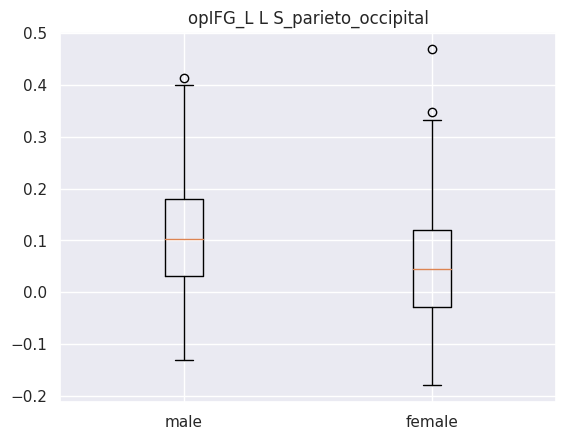

Ttest_indResult(statistic=6.503523668812626, pvalue=1.7355351061785972e-10)
male mean : 0.10978782784771862
female mean : 0.05152286066817276
                                  Region       Men     Women       P value
0      opIFG_L - L G_oc-temp_lat-fusifor  0.211650  0.166829  1.947666e-08
1      opIFG_L - L S_circular_insula_inf  0.179687  0.138314  1.145592e-08
2             opIFG_L - L S_temporal_sup  0.157560  0.115162  4.644482e-05
3  opIFG_L - L S_oc-temp_med_and_Lingual  0.148861  0.107018  3.974326e-09
4            opIFG_L - R G_insular_short  0.257298  0.209469  6.398857e-08
5              opIFG_L - R S_subparietal -0.033265 -0.082093  4.598637e-06
6               opIFG_L - L Lat_Fis-post  0.205084  0.150076  5.132542e-09
7      opIFG_L - L G_and_S_occipital_inf  0.148320  0.115457  8.422074e-04
8                opIFG_L - R G_front_sup  0.105248  0.066275  2.126944e-08
9        opIFG_L - L S_parieto_occipital  0.109788  0.051523  1.735535e-10


In [148]:
rois = ["opIFG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_opIFG_L)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions opIFG_R

     coefficient     seed                       labels
47      0.257032  opIFG_R      L S_circular_insula_inf
60      0.207552  opIFG_R  L S_oc-temp_med_and_Lingual
121     0.205102  opIFG_R      R S_circular_insula_inf
91      0.191789  opIFG_R            R G_insular_short
89      0.177847  opIFG_R                R G_front_sup
15      0.173893  opIFG_R                L G_front_sup
80      0.169734  opIFG_R     R G_and_S_cingul-Mid-Ant
125     0.165114  opIFG_R                R S_front_inf
108     0.164153  opIFG_R      R G_temp_sup-Plan_polar
41      0.157768  opIFG_R             L Pole_occipital
The mean accuracy : 0.8159159292035398
The standard deviation of the accuracy : 0.03799449876918694
The lower boundry of the confidance interval of the accuracy : 0.7414467116159335
The upper boundry of the confidance interval of the accuracy : 0.8903851467911462


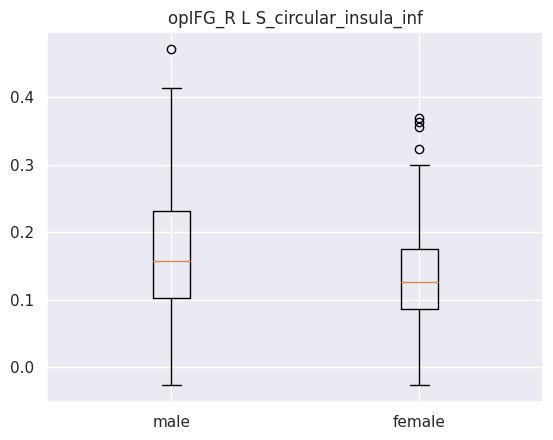

Ttest_indResult(statistic=4.729506412940881, pvalue=2.84980032551188e-06)
male mean : 0.16831194070988592
female mean : 0.13581089123421927


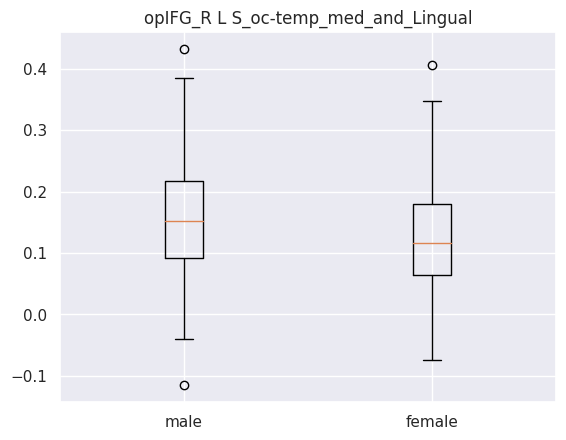

Ttest_indResult(statistic=4.683575774370304, pvalue=3.539150807108733e-06)
male mean : 0.15626952140722436
female mean : 0.12206103295259137


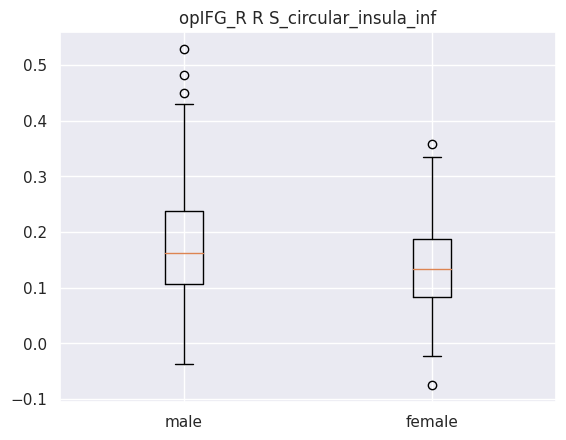

Ttest_indResult(statistic=4.942755677875544, pvalue=1.0181350777303932e-06)
male mean : 0.17446574005114068
female mean : 0.1389954879870432


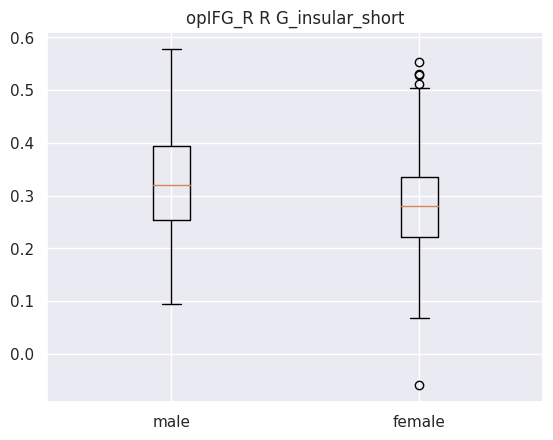

Ttest_indResult(statistic=4.755239251404364, pvalue=2.5221004207170377e-06)
male mean : 0.3230140808745247
female mean : 0.28459807252159475


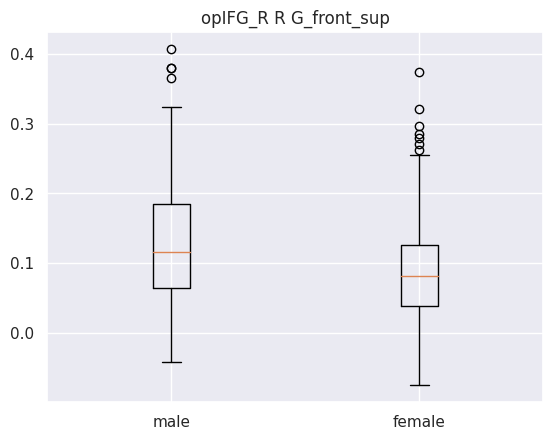

Ttest_indResult(statistic=5.745692358467039, pvalue=1.501515937789587e-08)
male mean : 0.1265730028612167
female mean : 0.08889572881594685


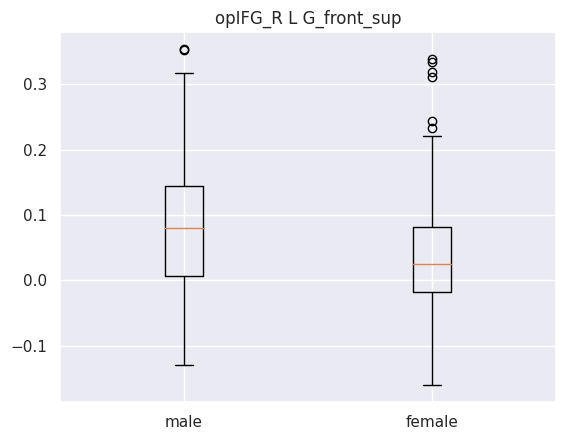

Ttest_indResult(statistic=5.840874265006819, pvalue=8.794027366847957e-09)
male mean : 0.07910377020205323
female mean : 0.03652195184581396


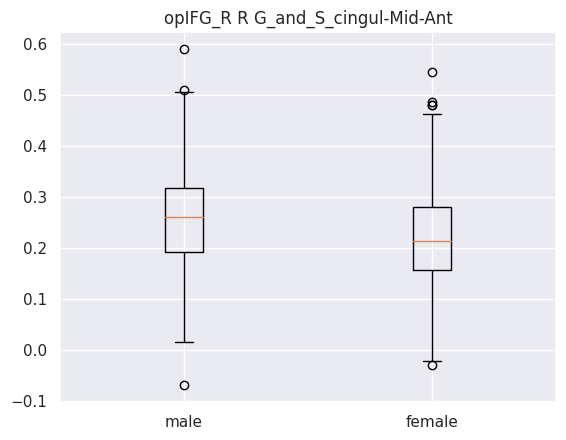

Ttest_indResult(statistic=4.315955845337449, pvalue=1.878004856996765e-05)
male mean : 0.2591957626121673
female mean : 0.22244813224916943


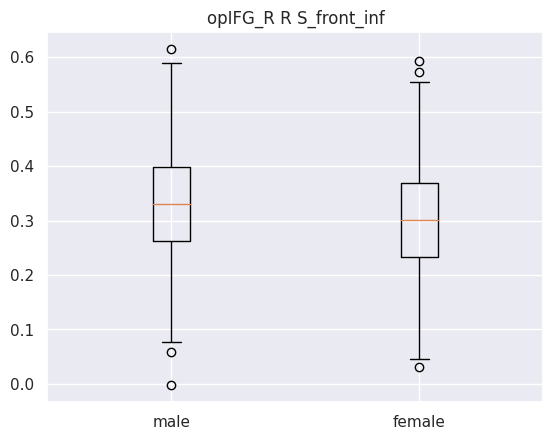

Ttest_indResult(statistic=3.5795531005665557, pvalue=0.0003739476663251471)
male mean : 0.33087263080000007
female mean : 0.29969864851495015


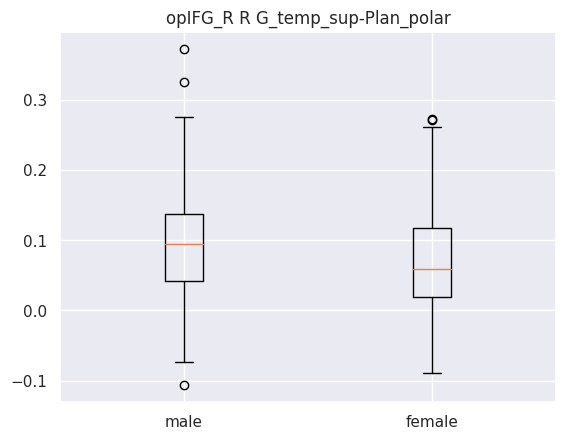

Ttest_indResult(statistic=3.998178487567644, pvalue=7.235199191609884e-05)
male mean : 0.09452694148326996
female mean : 0.07004874881162791


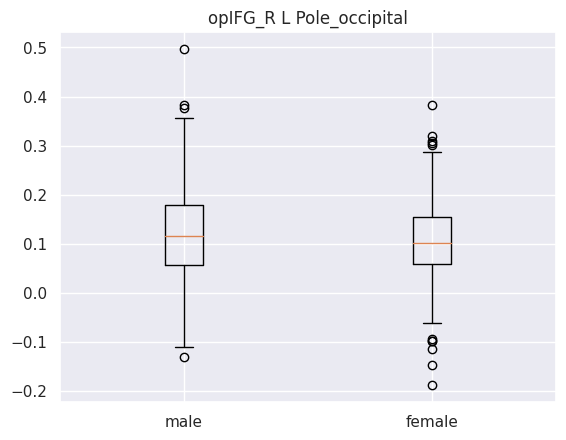

Ttest_indResult(statistic=2.2602421008901716, pvalue=0.0241880831961621)
male mean : 0.12250584151026614
female mean : 0.10541738842285715
                                  Region       Men     Women       P value
0      opIFG_R - L S_circular_insula_inf  0.168312  0.135811  2.849800e-06
1  opIFG_R - L S_oc-temp_med_and_Lingual  0.156270  0.122061  3.539151e-06
2      opIFG_R - R S_circular_insula_inf  0.174466  0.138995  1.018135e-06
3            opIFG_R - R G_insular_short  0.323014  0.284598  2.522100e-06
4                opIFG_R - R G_front_sup  0.126573  0.088896  1.501516e-08
5                opIFG_R - L G_front_sup  0.079104  0.036522  8.794027e-09
6     opIFG_R - R G_and_S_cingul-Mid-Ant  0.259196  0.222448  1.878005e-05
7                opIFG_R - R S_front_inf  0.330873  0.299699  3.739477e-04
8      opIFG_R - R G_temp_sup-Plan_polar  0.094527  0.070049  7.235199e-05
9             opIFG_R - L Pole_occipital  0.122506  0.105417  2.418808e-02


In [149]:
rois = ["opIFG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_opIFG_R)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions pITG_L

     coefficient    seed                       labels
47      0.240166  pITG_L      L S_circular_insula_inf
26      0.238076  pITG_L             L G_parietal_sup
9       0.203500  pITG_L      L G_cingul-Post-ventral
20      0.200224  pITG_L      L G_oc-temp_lat-fusifor
55      0.181368  pITG_L  L S_intrapariet_and_P_trans
83      0.172106  pITG_L      R G_cingul-Post-ventral
75      0.167198  pITG_L      R G_and_S_occipital_inf
125     0.164939  pITG_L                R S_front_inf
60      0.154554  pITG_L  L S_oc-temp_med_and_Lingual
86      0.153020  pITG_L        R G_front_inf-Orbital
The mean accuracy : 0.8111796460176992
The standard deviation of the accuracy : 0.03836824951793555
The lower boundry of the confidance interval of the accuracy : 0.7359778769625456
The upper boundry of the confidance interval of the accuracy : 0.8863814150728528


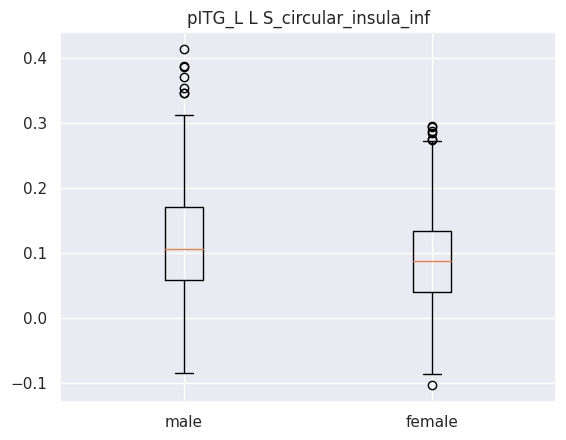

Ttest_indResult(statistic=3.7195183926587134, pvalue=0.00021963865781551026)
male mean : 0.1174053472373384
female mean : 0.09239644204584717


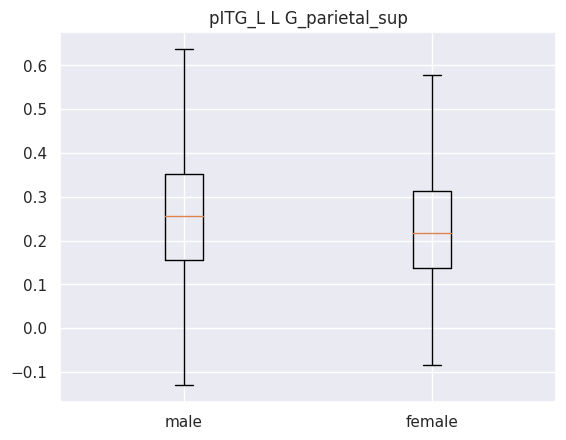

Ttest_indResult(statistic=2.0348237485458296, pvalue=0.04233743219572547)
male mean : 0.25056911626197714
female mean : 0.22777261343820598


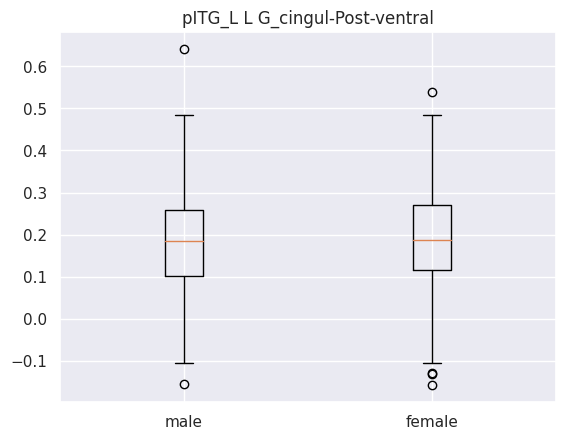

Ttest_indResult(statistic=-0.6639053665916427, pvalue=0.5070231460745944)
male mean : 0.18444210613802278
female mean : 0.19087066787209303


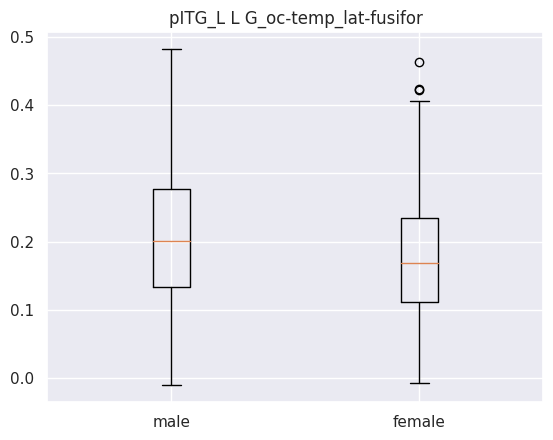

Ttest_indResult(statistic=3.2436073154022718, pvalue=0.001250320411852697)
male mean : 0.2056987803380228
female mean : 0.18023744266279068


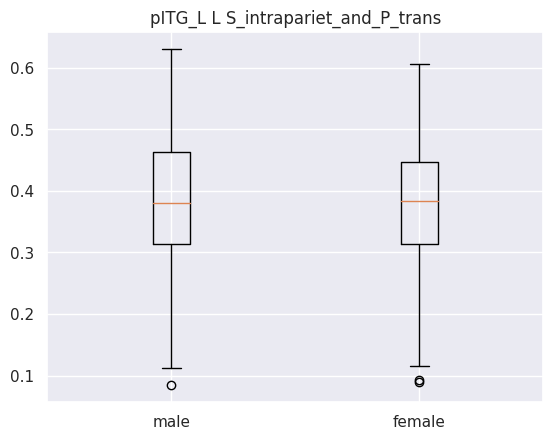

Ttest_indResult(statistic=0.27040597084376106, pvalue=0.7869472193855935)
male mean : 0.38125740577946765
female mean : 0.37889768367441856


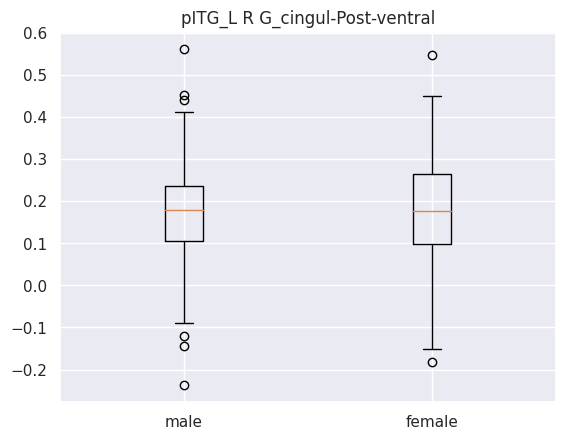

Ttest_indResult(statistic=-0.7087886870276421, pvalue=0.47874952082168243)
male mean : 0.17141985658456652
female mean : 0.17828767616757477


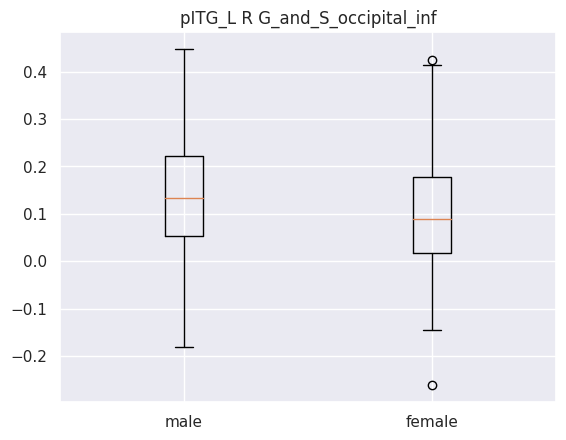

Ttest_indResult(statistic=3.1426765548050595, pvalue=0.0017623399666327859)
male mean : 0.13541462136387833
female mean : 0.10348527198348836


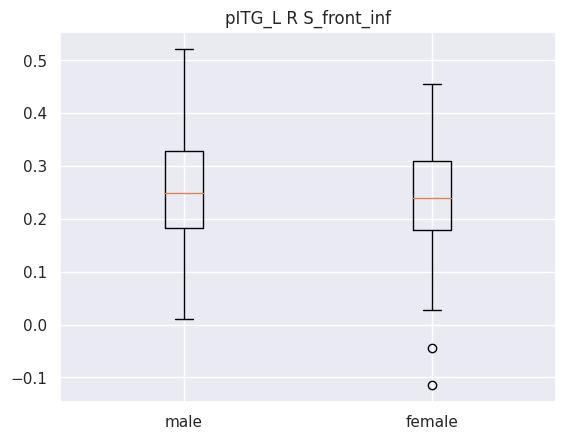

Ttest_indResult(statistic=2.0737617244228934, pvalue=0.0385563187021098)
male mean : 0.25845339727756655
female mean : 0.24180414809966774


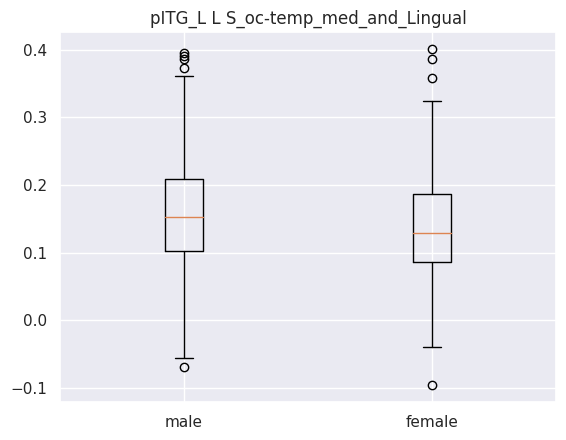

Ttest_indResult(statistic=3.01993636806222, pvalue=0.002643129220462383)
male mean : 0.1601642877536882
female mean : 0.13959590949933556


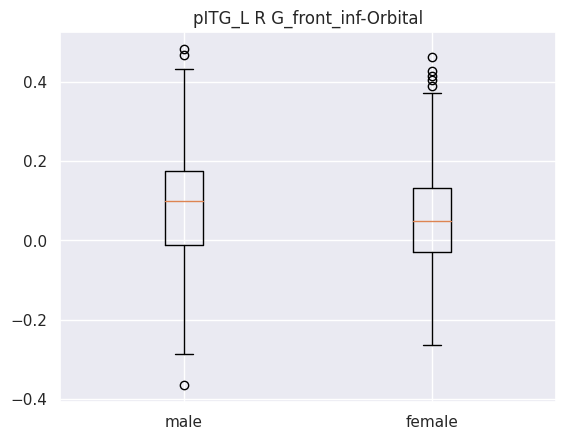

Ttest_indResult(statistic=2.4606260312415023, pvalue=0.014169135796902566)
male mean : 0.08827093163688214
female mean : 0.05931472846877077
                                 Region       Men     Women   P value
0      pITG_L - L S_circular_insula_inf  0.117405  0.092396  0.000220
1             pITG_L - L G_parietal_sup  0.250569  0.227773  0.042337
2      pITG_L - L G_cingul-Post-ventral  0.184442  0.190871  0.507023
3      pITG_L - L G_oc-temp_lat-fusifor  0.205699  0.180237  0.001250
4  pITG_L - L S_intrapariet_and_P_trans  0.381257  0.378898  0.786947
5      pITG_L - R G_cingul-Post-ventral  0.171420  0.178288  0.478750
6      pITG_L - R G_and_S_occipital_inf  0.135415  0.103485  0.001762
7                pITG_L - R S_front_inf  0.258453  0.241804  0.038556
8  pITG_L - L S_oc-temp_med_and_Lingual  0.160164  0.139596  0.002643
9        pITG_L - R G_front_inf-Orbital  0.088271  0.059315  0.014169


In [150]:
rois = ["pITG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_pITG_L)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions pITG_R

     coefficient    seed                   labels
20      0.268079  pITG_R  L G_oc-temp_lat-fusifor
72      0.258256  pITG_R         L S_temporal_sup
83      0.229686  pITG_R  R G_cingul-Post-ventral
47      0.206474  pITG_R  L S_circular_insula_inf
84      0.189709  pITG_R               R G_cuneus
108     0.172699  pITG_R  R G_temp_sup-Plan_polar
125     0.172169  pITG_R            R S_front_inf
106     0.160596  pITG_R  R G_temp_sup-G_T_transv
91      0.157899  pITG_R        R G_insular_short
144     0.157739  pITG_R          R S_subparietal
The mean accuracy : 0.8024017699115045
The standard deviation of the accuracy : 0.038776032628394415
The lower boundry of the confidance interval of the accuracy : 0.7264007459598514
The upper boundry of the confidance interval of the accuracy : 0.8784027938631576


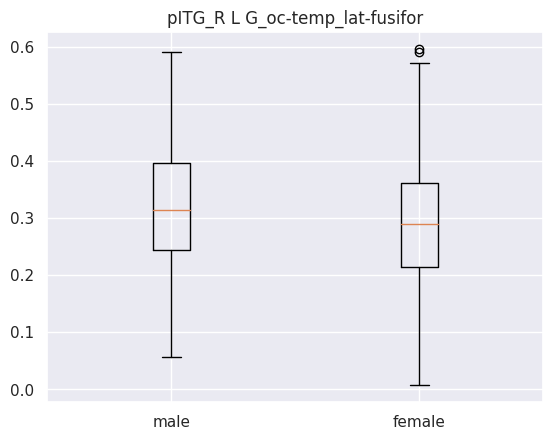

Ttest_indResult(statistic=2.810268986820924, pvalue=0.0051225200608808474)
male mean : 0.31478116888212926
female mean : 0.2893303569966777


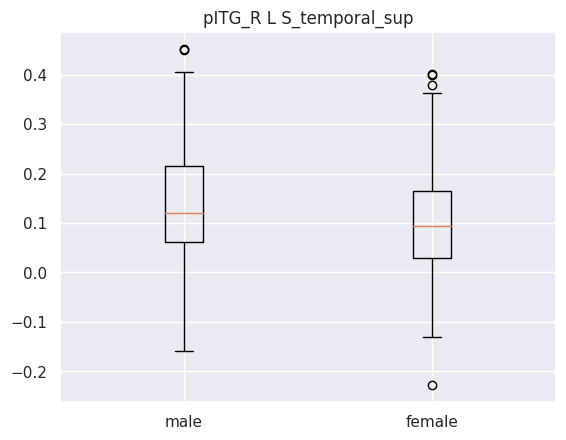

Ttest_indResult(statistic=4.196741356631083, pvalue=3.1469933747888905e-05)
male mean : 0.13739067075551334
female mean : 0.09954083086165548


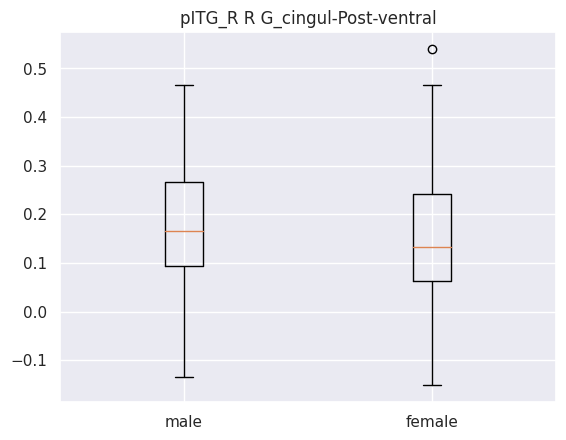

Ttest_indResult(statistic=2.256297345157703, pvalue=0.024435481782569664)
male mean : 0.1744766429752852
female mean : 0.15124980597607973


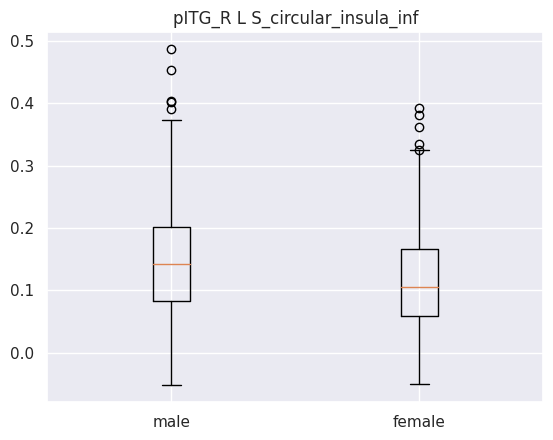

Ttest_indResult(statistic=4.781913144179267, pvalue=2.220814202786064e-06)
male mean : 0.15037180967528518
female mean : 0.1155669789617608


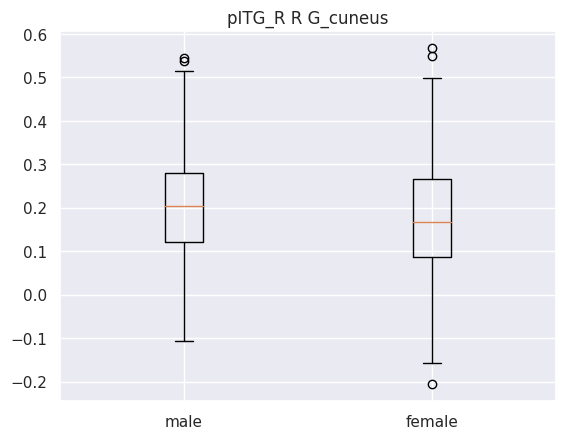

Ttest_indResult(statistic=2.741944633725931, pvalue=0.006302259674511262)
male mean : 0.20491106910646387
female mean : 0.17536686928538206


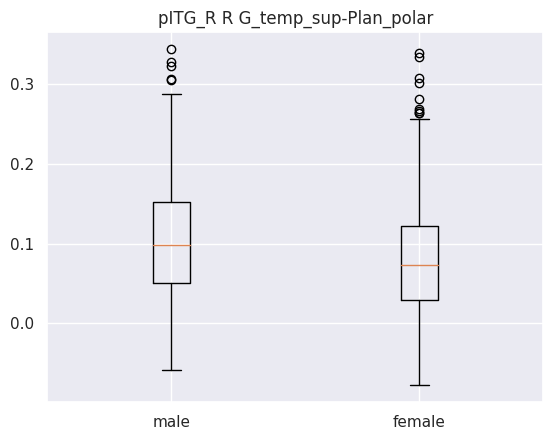

Ttest_indResult(statistic=3.829041740563084, pvalue=0.00014311201699602173)
male mean : 0.10721168719125476
female mean : 0.08294021107918272


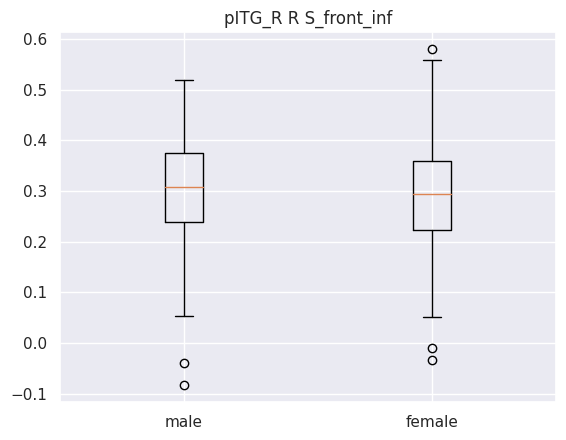

Ttest_indResult(statistic=1.6379189328233394, pvalue=0.10199833222671245)
male mean : 0.3043051077718631
female mean : 0.29073446122923585


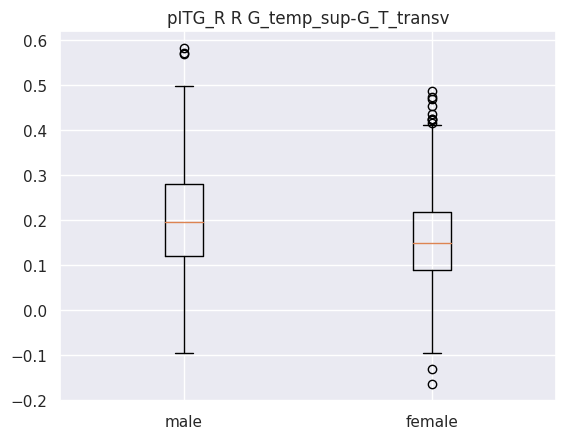

Ttest_indResult(statistic=4.858246945744738, pvalue=1.5379842834630926e-06)
male mean : 0.20724551101216732
female mean : 0.16001330873255815


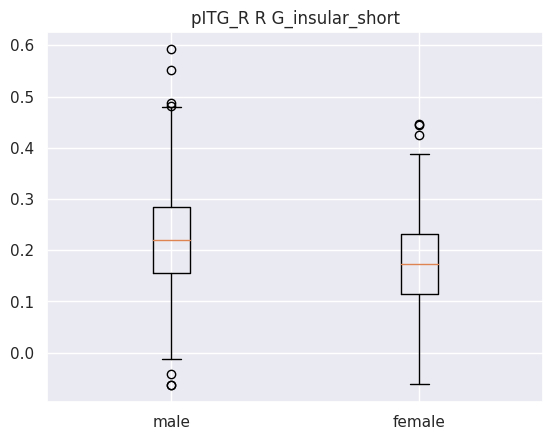

Ttest_indResult(statistic=5.697103263903745, pvalue=1.9674615344309902e-08)
male mean : 0.2223536750768061
female mean : 0.1753717551358804


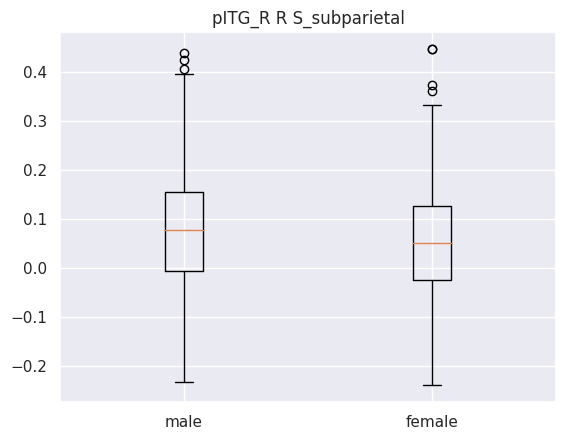

Ttest_indResult(statistic=2.373555580211466, pvalue=0.01795294789038577)
male mean : 0.08108263206159695
female mean : 0.05675384893664452
                             Region       Men     Women       P value
0  pITG_R - L G_oc-temp_lat-fusifor  0.314781  0.289330  5.122520e-03
1         pITG_R - L S_temporal_sup  0.137391  0.099541  3.146993e-05
2  pITG_R - R G_cingul-Post-ventral  0.174477  0.151250  2.443548e-02
3  pITG_R - L S_circular_insula_inf  0.150372  0.115567  2.220814e-06
4               pITG_R - R G_cuneus  0.204911  0.175367  6.302260e-03
5  pITG_R - R G_temp_sup-Plan_polar  0.107212  0.082940  1.431120e-04
6            pITG_R - R S_front_inf  0.304305  0.290734  1.019983e-01
7  pITG_R - R G_temp_sup-G_T_transv  0.207246  0.160013  1.537984e-06
8        pITG_R - R G_insular_short  0.222354  0.175372  1.967462e-08
9          pITG_R - R S_subparietal  0.081083  0.056754  1.795295e-02


In [151]:
rois = ["pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_pITG_R)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions planumtemp_L

     coefficient          seed                       labels
60      0.318987  planumtemp_L  L S_oc-temp_med_and_Lingual
20      0.221324  planumtemp_L      L G_oc-temp_lat-fusifor
108     0.205293  planumtemp_L      R G_temp_sup-Plan_polar
15      0.204476  planumtemp_L                L G_front_sup
94      0.177732  planumtemp_L      R G_oc-temp_lat-fusifor
43      0.171312  planumtemp_L                L S_calcarine
99      0.168395  planumtemp_L      R G_pariet_inf-Supramar
89      0.163267  planumtemp_L                R G_front_sup
88      0.162727  planumtemp_L             R G_front_middle
30      0.156225  planumtemp_L                   L G_rectus
The mean accuracy : 0.8016619469026549
The standard deviation of the accuracy : 0.03884471028280589
The lower boundry of the confidance interval of the accuracy : 0.7255263147483554
The upper boundry of the confidance interval of the accuracy : 0.8777975790569544


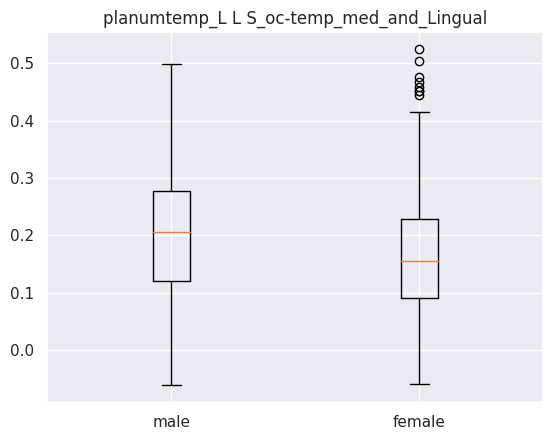

Ttest_indResult(statistic=3.5535200840172108, pvalue=0.0004120710964530877)
male mean : 0.20138468446653993
female mean : 0.1691071645282392


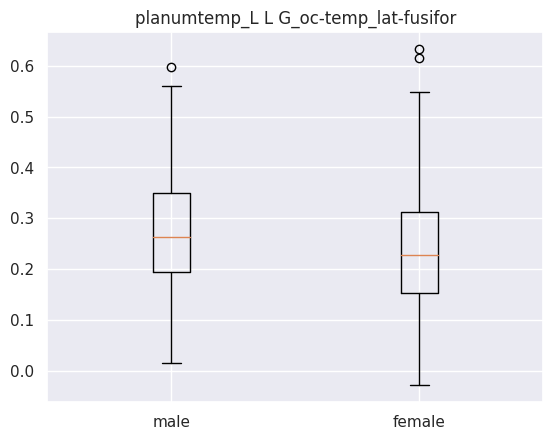

Ttest_indResult(statistic=3.8640363181268467, pvalue=0.00012453051309743143)
male mean : 0.273934721608365
female mean : 0.23664216192325582


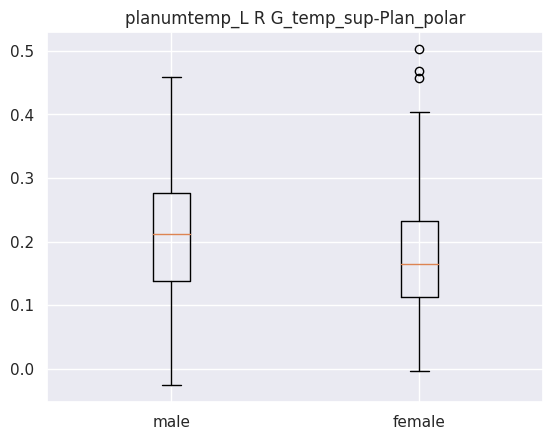

Ttest_indResult(statistic=4.754095906522838, pvalue=2.535856882720888e-06)
male mean : 0.2124789285969582
female mean : 0.1759663873843854


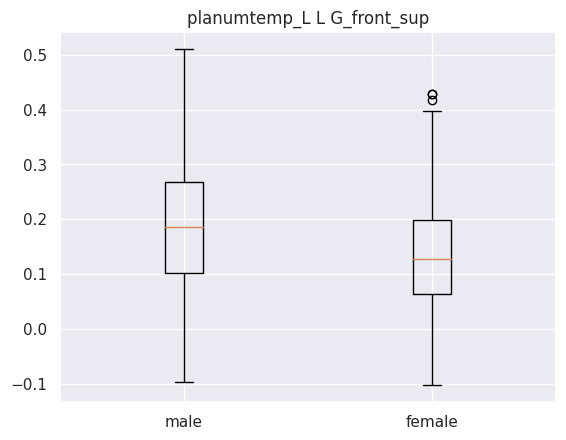

Ttest_indResult(statistic=5.407175582759948, pvalue=9.480994088922564e-08)
male mean : 0.1847222246946768
female mean : 0.1378197862071096


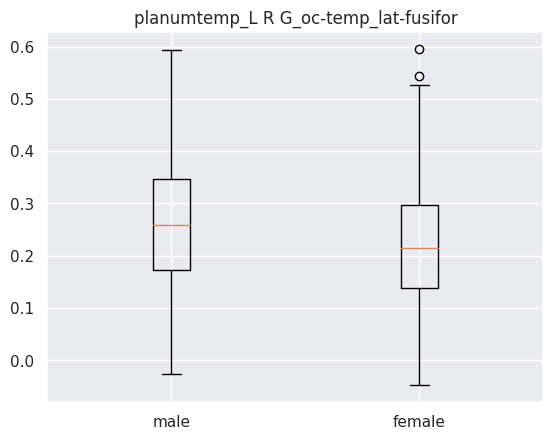

Ttest_indResult(statistic=3.691296784762628, pvalue=0.00024485362854647204)
male mean : 0.26207624817110264
female mean : 0.22636467401827245


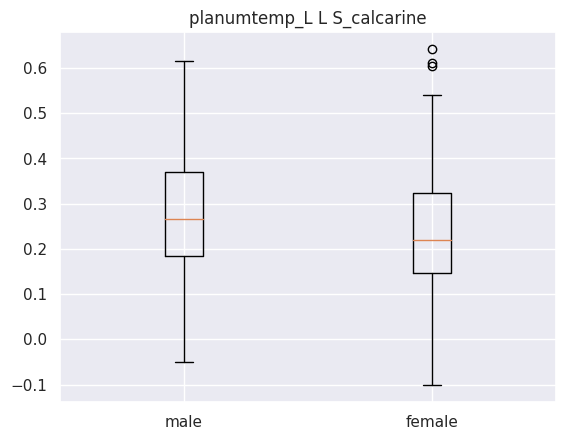

Ttest_indResult(statistic=3.141316233107298, pvalue=0.001770403211946406)
male mean : 0.274296150904943
female mean : 0.2400809567398671


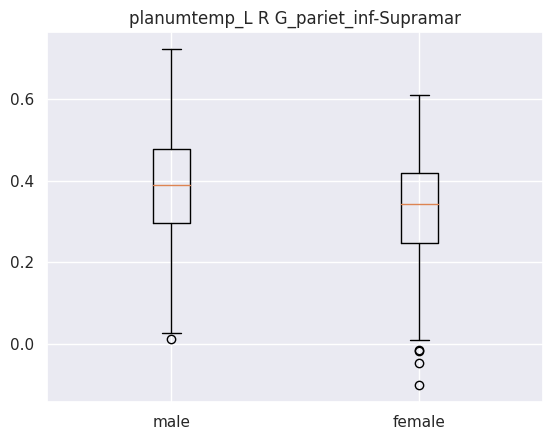

Ttest_indResult(statistic=4.712576838267088, pvalue=3.0873356981406085e-06)
male mean : 0.38310964460076047
female mean : 0.3312813015614618


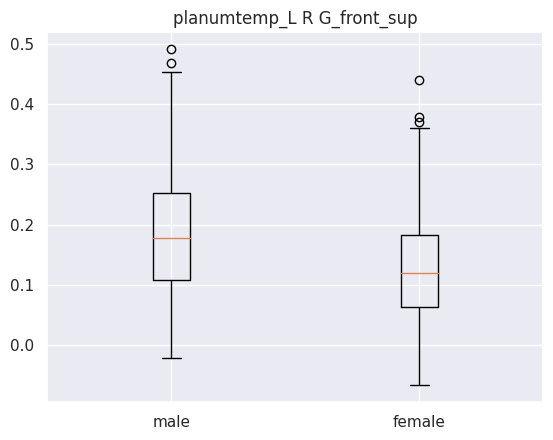

Ttest_indResult(statistic=7.005723286524496, pvalue=7.053092520728604e-12)
male mean : 0.1842207737676046
female mean : 0.12974268123255814


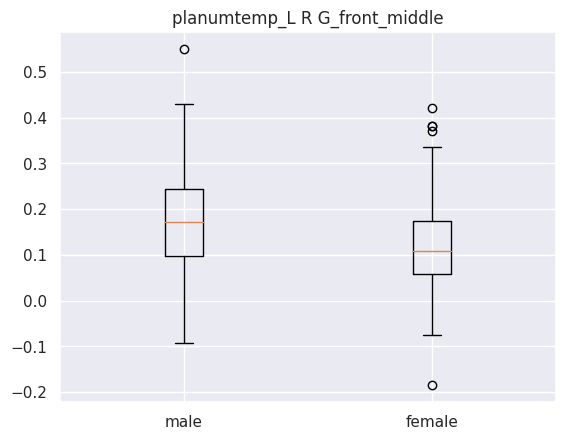

Ttest_indResult(statistic=7.083051952003173, pvalue=4.234418336006045e-12)
male mean : 0.17561467015703422
female mean : 0.11818345196269103


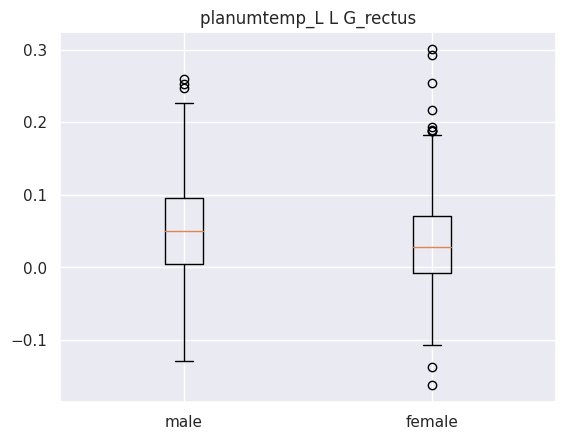

Ttest_indResult(statistic=2.7512545363189393, pvalue=0.006128244861950536)
male mean : 0.05109769466604562
female mean : 0.035068776211362125
                                       Region       Men     Women  \
0  planumtemp_L - L S_oc-temp_med_and_Lingual  0.201385  0.169107   
1      planumtemp_L - L G_oc-temp_lat-fusifor  0.273935  0.236642   
2      planumtemp_L - R G_temp_sup-Plan_polar  0.212479  0.175966   
3                planumtemp_L - L G_front_sup  0.184722  0.137820   
4      planumtemp_L - R G_oc-temp_lat-fusifor  0.262076  0.226365   
5                planumtemp_L - L S_calcarine  0.274296  0.240081   
6      planumtemp_L - R G_pariet_inf-Supramar  0.383110  0.331281   
7                planumtemp_L - R G_front_sup  0.184221  0.129743   
8             planumtemp_L - R G_front_middle  0.175615  0.118183   
9                   planumtemp_L - L G_rectus  0.051098  0.035069   

        P value  
0  4.120711e-04  
1  1.245305e-04  
2  2.535857e-06  
3  9.480994e-08  
4  2.448

In [152]:
rois = ["planumtemp_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_planumtemp_L)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions planumtemp_R

     coefficient          seed                       labels
47      0.258000  planumtemp_R      L S_circular_insula_inf
108     0.250284  planumtemp_R      R G_temp_sup-Plan_polar
60      0.236093  planumtemp_R  L S_oc-temp_med_and_Lingual
43      0.220355  planumtemp_R                L S_calcarine
15      0.206736  planumtemp_R                L G_front_sup
72      0.192519  planumtemp_R             L S_temporal_sup
121     0.173699  planumtemp_R      R S_circular_insula_inf
139     0.170760  planumtemp_R             R S_pericallosal
58      0.151122  planumtemp_R            L S_occipital_ant
20      0.148373  planumtemp_R      L G_oc-temp_lat-fusifor
The mean accuracy : 0.7947115044247788
The standard deviation of the accuracy : 0.03976175647254694
The lower boundry of the confidance interval of the accuracy : 0.7167784617385868
The upper boundry of the confidance interval of the accuracy : 0.8726445471109707


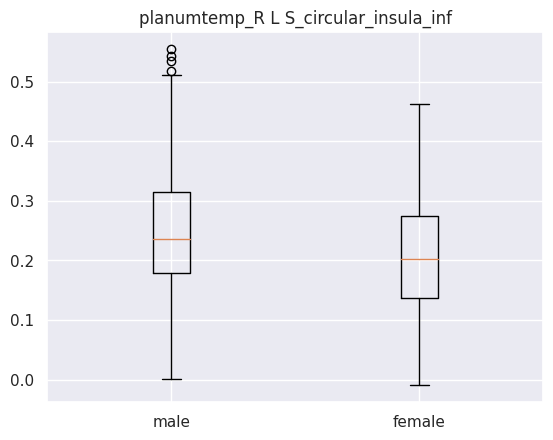

Ttest_indResult(statistic=4.754592848867569, pvalue=2.5298689374709147e-06)
male mean : 0.24664524678136882
female mean : 0.20796517266445183


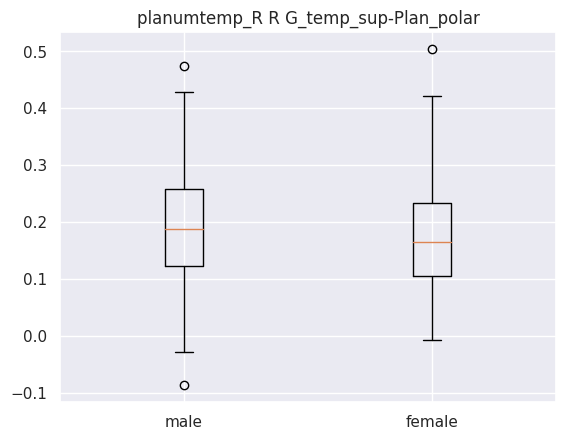

Ttest_indResult(statistic=2.321906417293724, pvalue=0.02059447944633167)
male mean : 0.19231692340304182
female mean : 0.17497604091495014


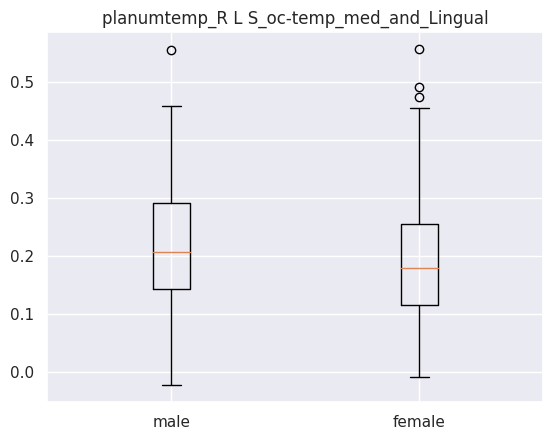

Ttest_indResult(statistic=2.8830998134021852, pvalue=0.004088548964724054)
male mean : 0.21623359568707226
female mean : 0.1909124683142857


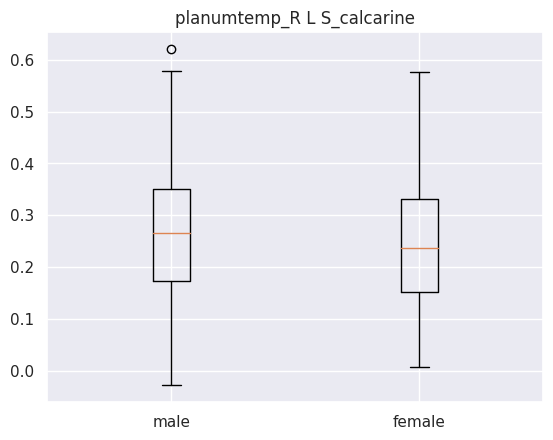

Ttest_indResult(statistic=2.002991768199032, pvalue=0.045657919237324006)
male mean : 0.26823541858505706
female mean : 0.24731367291561462


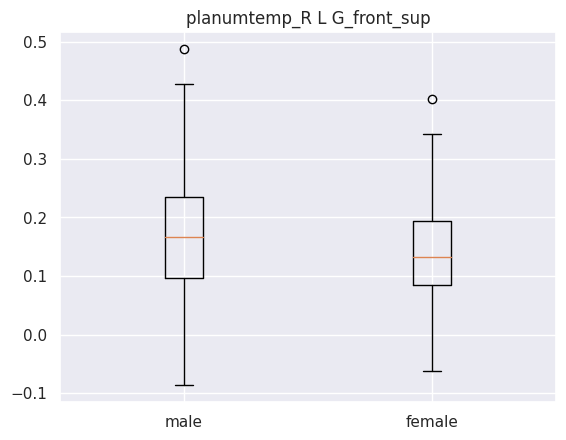

Ttest_indResult(statistic=3.245882136071958, pvalue=0.0012405568276112682)
male mean : 0.16498520389163499
female mean : 0.1399915779053156


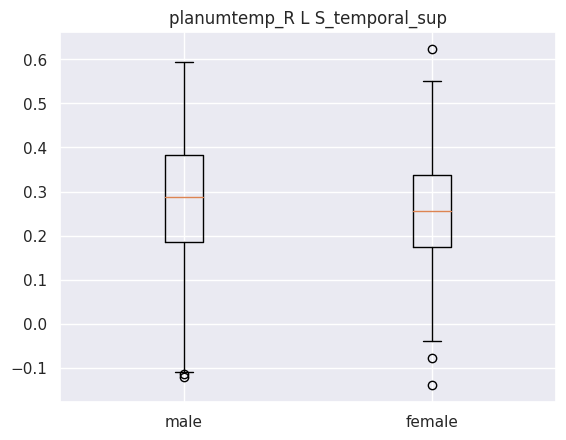

Ttest_indResult(statistic=1.9939713075469714, pvalue=0.04663794806816013)
male mean : 0.27949129047262355
female mean : 0.2574814225966777


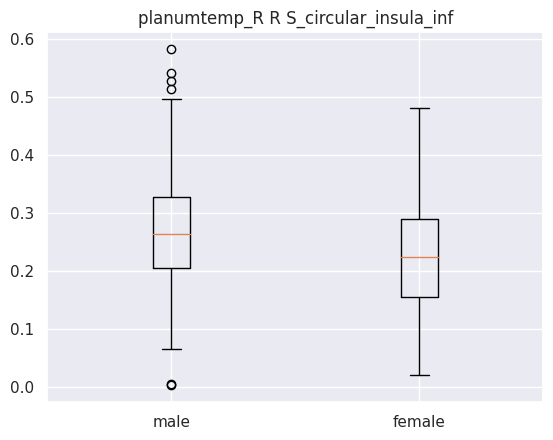

Ttest_indResult(statistic=4.926397277096471, pvalue=1.103284155465702e-06)
male mean : 0.2661869187410647
female mean : 0.22700655812956813


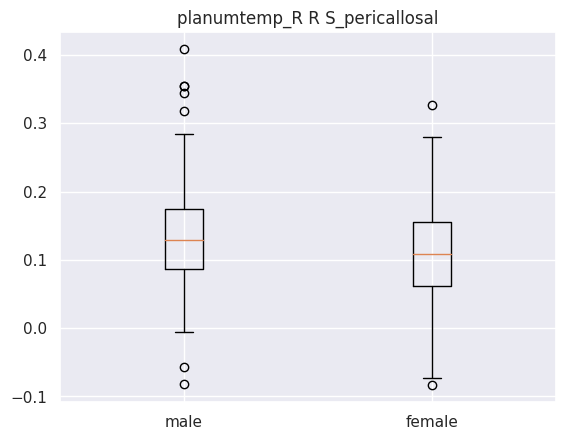

Ttest_indResult(statistic=4.21027853272709, pvalue=2.969654392292594e-05)
male mean : 0.13301439208163496
female mean : 0.1079359846166113


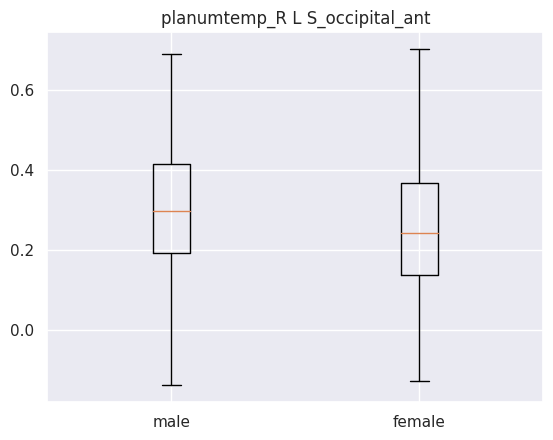

Ttest_indResult(statistic=3.428455086580389, pvalue=0.000651502448703635)
male mean : 0.2995649025620913
female mean : 0.25357602423322256


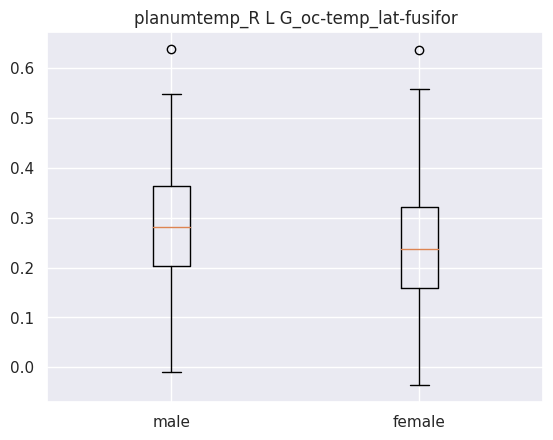

Ttest_indResult(statistic=4.153958282783595, pvalue=3.77618536555217e-05)
male mean : 0.28594790805589354
female mean : 0.24477274405647842
                                       Region       Men     Women   P value
0      planumtemp_R - L S_circular_insula_inf  0.246645  0.207965  0.000003
1      planumtemp_R - R G_temp_sup-Plan_polar  0.192317  0.174976  0.020594
2  planumtemp_R - L S_oc-temp_med_and_Lingual  0.216234  0.190912  0.004089
3                planumtemp_R - L S_calcarine  0.268235  0.247314  0.045658
4                planumtemp_R - L G_front_sup  0.164985  0.139992  0.001241
5             planumtemp_R - L S_temporal_sup  0.279491  0.257481  0.046638
6      planumtemp_R - R S_circular_insula_inf  0.266187  0.227007  0.000001
7             planumtemp_R - R S_pericallosal  0.133014  0.107936  0.000030
8            planumtemp_R - L S_occipital_ant  0.299565  0.253576  0.000652
9      planumtemp_R - L G_oc-temp_lat-fusifor  0.285948  0.244773  0.000038


In [153]:
rois = ["planumtemp_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_planumtemp_R)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions for all left seeds

     coefficient     seed                       labels
98      0.129544  opIFG_L       R G_pariet_inf-Angular
55      0.113597  opIFG_L  L S_intrapariet_and_P_trans
322     0.113110   aMTG_L             L G_parietal_sup
53      0.111013  opIFG_L                L S_front_sup
504     0.102529   pITG_L  L S_oc-temp_med_and_Lingual
66      0.092603  opIFG_L              L S_postcentral
460     0.092465   pITG_L    L G_Ins_lg_and_S_cent_ins
135     0.091490  opIFG_L          R S_orbital_lateral
421     0.082751   aMTG_L                R S_front_inf
351     0.082314   aMTG_L  L S_intrapariet_and_P_trans
The mean accuracy : 0.9100008849557522
The standard deviation of the accuracy : 0.02859329420494401
The lower boundry of the confidance interval of the accuracy : 0.8539580283140619
The upper boundry of the confidance interval of the accuracy : 0.9660437415974424


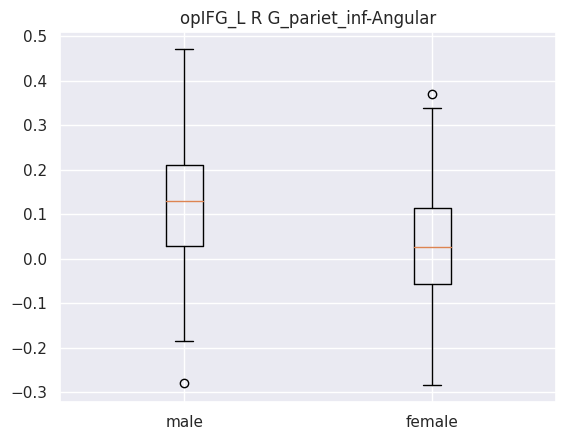

Ttest_indResult(statistic=7.716695110055561, pvalue=5.480751648776057e-14)
male mean : 0.11766997985152092
female mean : 0.03601953544850498


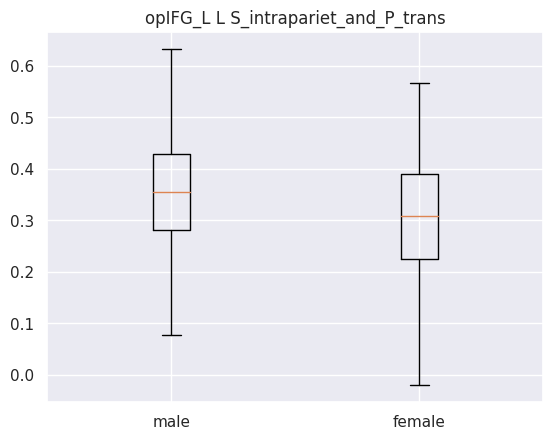

Ttest_indResult(statistic=5.055350828931209, pvalue=5.821781911163281e-07)
male mean : 0.35213074777946773
female mean : 0.3031099729109635


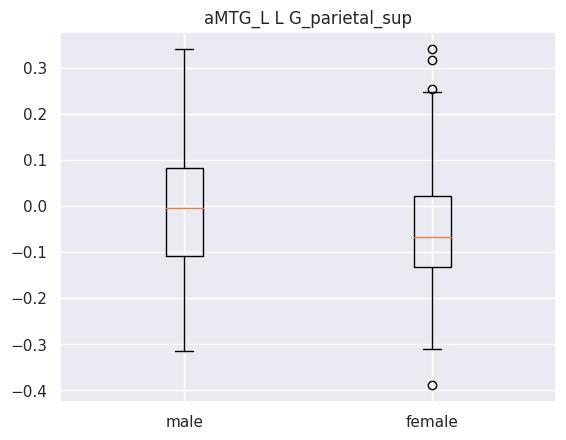

Ttest_indResult(statistic=4.059890719730225, pvalue=5.606265792321045e-05)
male mean : -0.006850357185019011
female mean : -0.05038483464086378


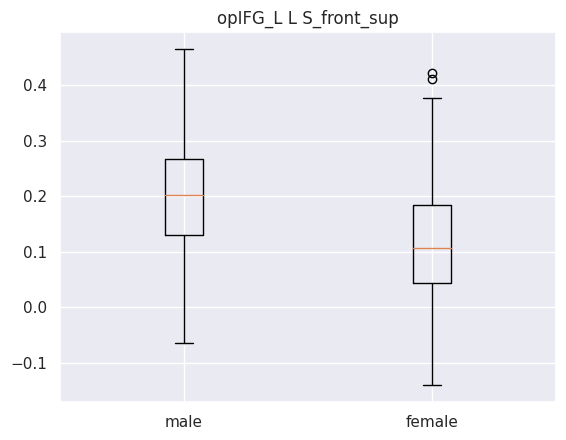

Ttest_indResult(statistic=10.006029115486237, pvalue=8.422510097736992e-22)
male mean : 0.1996858131581749
female mean : 0.11606861896099667


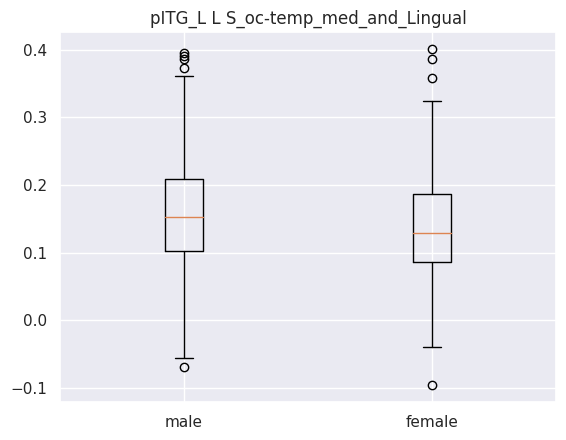

Ttest_indResult(statistic=3.01993636806222, pvalue=0.002643129220462383)
male mean : 0.1601642877536882
female mean : 0.13959590949933556


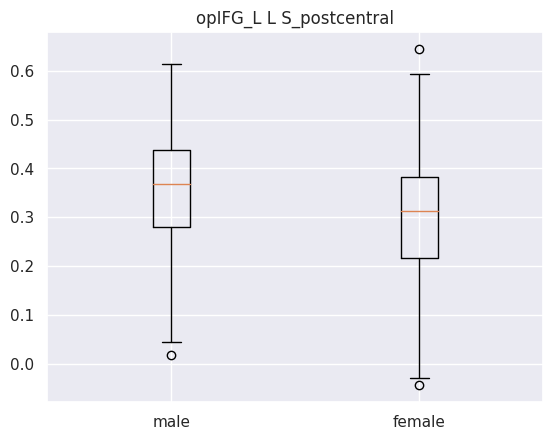

Ttest_indResult(statistic=6.164168782870945, pvalue=1.3532257302585482e-09)
male mean : 0.36117898896577944
female mean : 0.29792533494119594


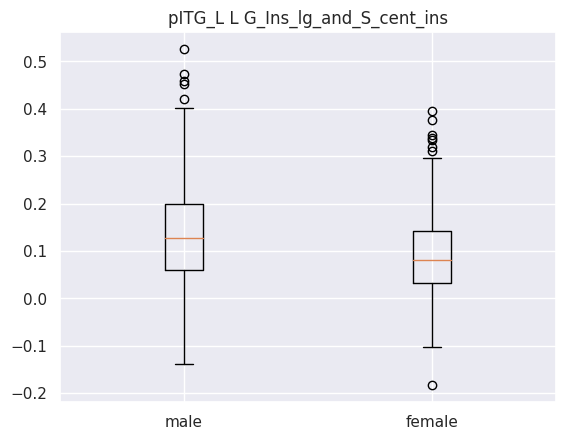

Ttest_indResult(statistic=5.375595899137657, pvalue=1.1205421040305568e-07)
male mean : 0.13588157877680607
female mean : 0.09083962553239203


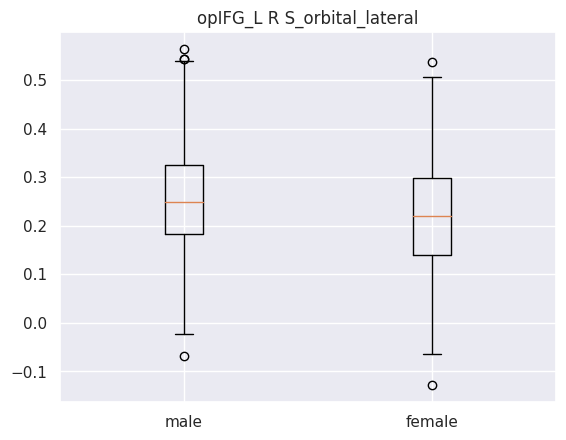

Ttest_indResult(statistic=3.4854763518784595, pvalue=0.0005296037092508647)
male mean : 0.2535425955125475
female mean : 0.2189224686335548


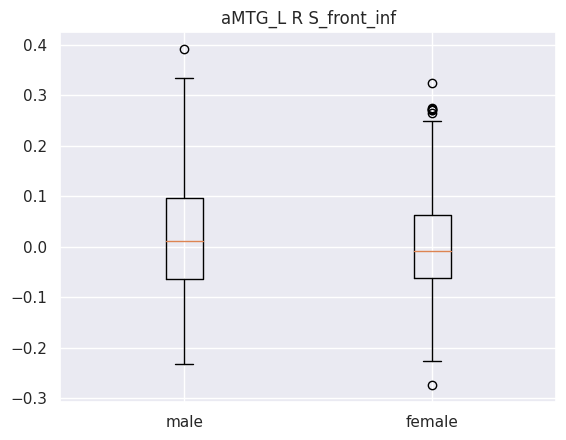

Ttest_indResult(statistic=1.520196297164563, pvalue=0.12902402830858953)
male mean : 0.01492980324942966
female mean : 0.0012906573921926926


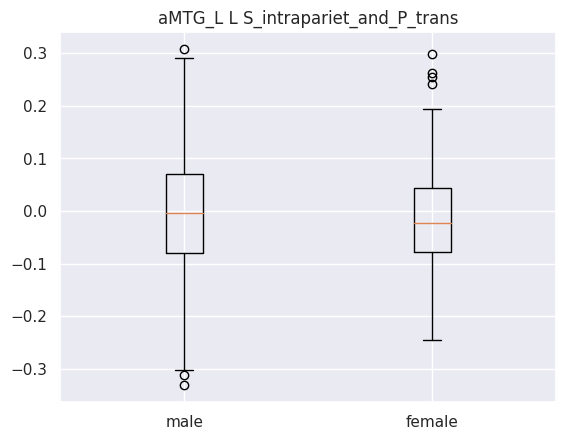

Ttest_indResult(statistic=0.9647641183387371, pvalue=0.3350779189775276)
male mean : -0.004121455086692014
female mean : -0.012516677279534883
                                  Region       Men     Women       P value
0       opIFG_L - R G_pariet_inf-Angular  0.117670  0.036020  5.480752e-14
1  opIFG_L - L S_intrapariet_and_P_trans  0.352131  0.303110  5.821782e-07
2              aMTG_L - L G_parietal_sup -0.006850 -0.050385  5.606266e-05
3                opIFG_L - L S_front_sup  0.199686  0.116069  8.422510e-22
4   pITG_L - L S_oc-temp_med_and_Lingual  0.160164  0.139596  2.643129e-03
5              opIFG_L - L S_postcentral  0.361179  0.297925  1.353226e-09
6     pITG_L - L G_Ins_lg_and_S_cent_ins  0.135882  0.090840  1.120542e-07
7          opIFG_L - R S_orbital_lateral  0.253543  0.218922  5.296037e-04
8                 aMTG_L - R S_front_inf  0.014930  0.001291  1.290240e-01
9   aMTG_L - L S_intrapariet_and_P_trans -0.004121 -0.012517  3.350779e-01


In [154]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_left)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Best regions of all right seeds

     coefficient          seed                       labels
487     0.118662        pITG_R                L S_calcarine
504     0.105718        pITG_R  L S_oc-temp_med_and_Lingual
90      0.102234       opIFG_R    R G_Ins_lg_and_S_cent_ins
66      0.101487       opIFG_R              L S_postcentral
22      0.101259       opIFG_R      L G_oc-temp_med-Parahip
421     0.101095        aMTG_R                R S_front_inf
231     0.100313  planumtemp_R      R G_cingul-Post-ventral
459     0.100124        pITG_R                L G_front_sup
440     0.099942        aMTG_R              R S_subparietal
343     0.098722        aMTG_R      L S_circular_insula_inf
The mean accuracy : 0.8987194690265485
The standard deviation of the accuracy : 0.030543593531264734
The lower boundry of the confidance interval of the accuracy : 0.8388540257052697
The upper boundry of the confidance interval of the accuracy : 0.9585849123478274


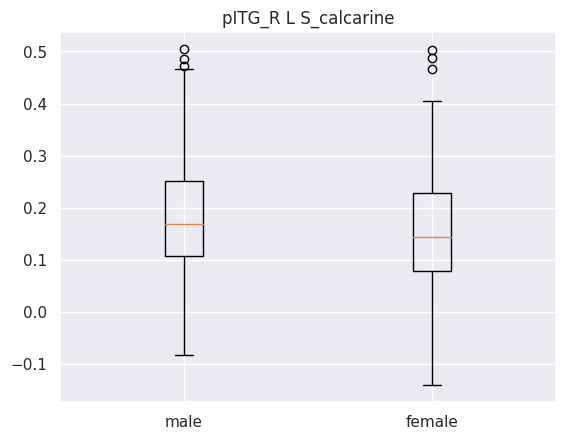

Ttest_indResult(statistic=3.2351347094550422, pvalue=0.0012873143650390924)
male mean : 0.18480961091102663
female mean : 0.1554359898385382


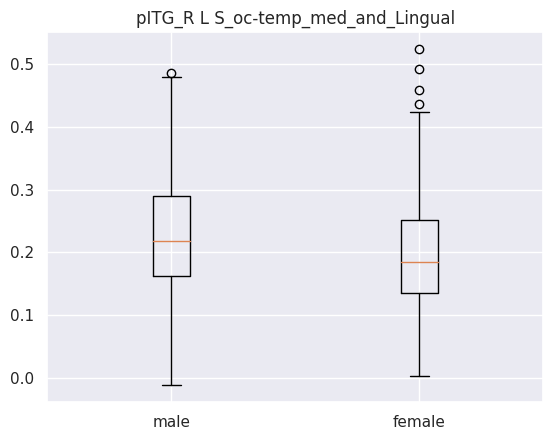

Ttest_indResult(statistic=3.658497216134596, pvalue=0.00027757468582203013)
male mean : 0.2244769810418251
female mean : 0.19555248922657806


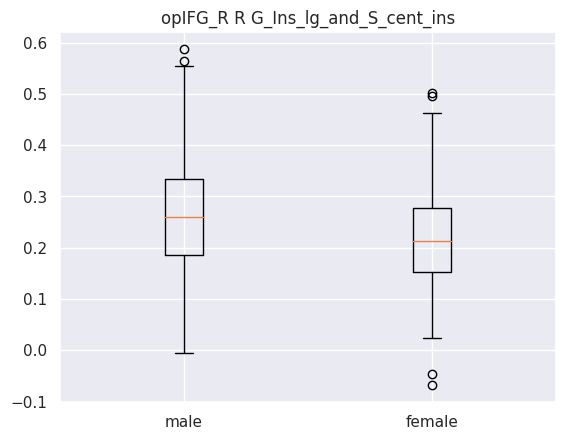

Ttest_indResult(statistic=5.071136490485997, pvalue=5.378396910376465e-07)
male mean : 0.26213691595703426
female mean : 0.21789970354485053


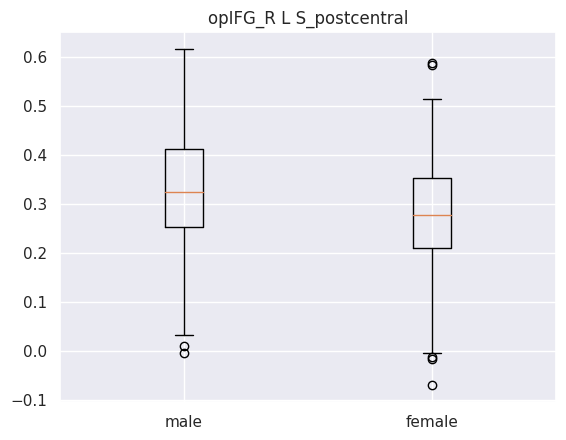

Ttest_indResult(statistic=5.271054566169988, pvalue=1.9369475536514105e-07)
male mean : 0.32780815557186316
female mean : 0.27874649102691035


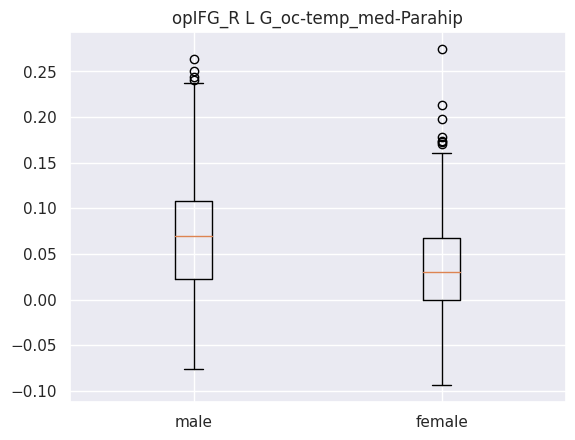

Ttest_indResult(statistic=6.251330329526955, pvalue=8.05447977290333e-10)
male mean : 0.06960421543711026
female mean : 0.0386048876523588


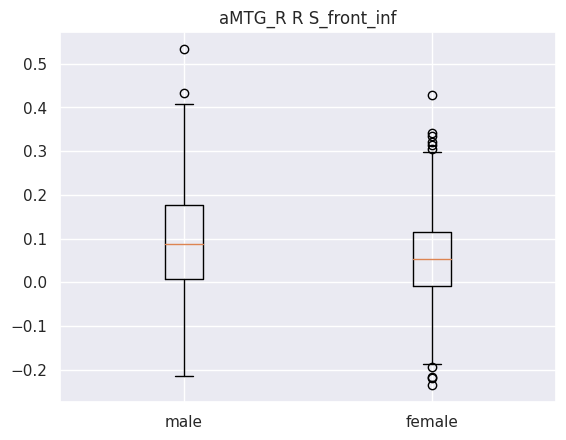

Ttest_indResult(statistic=4.148252422200393, pvalue=3.868639529214971e-05)
male mean : 0.09520096379193917
female mean : 0.055367278695980064


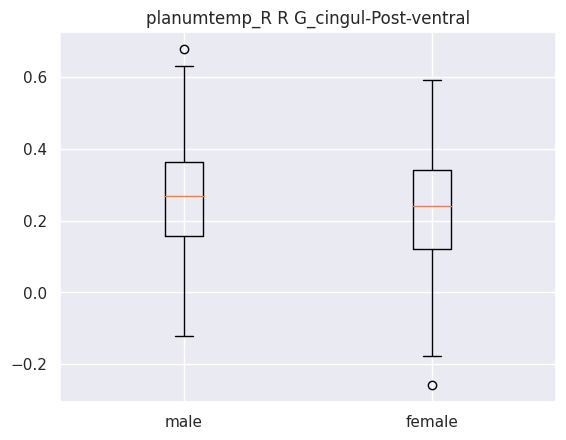

Ttest_indResult(statistic=2.475346691636639, pvalue=0.013604413951231341)
male mean : 0.26356463188897344
female mean : 0.23156667134385378


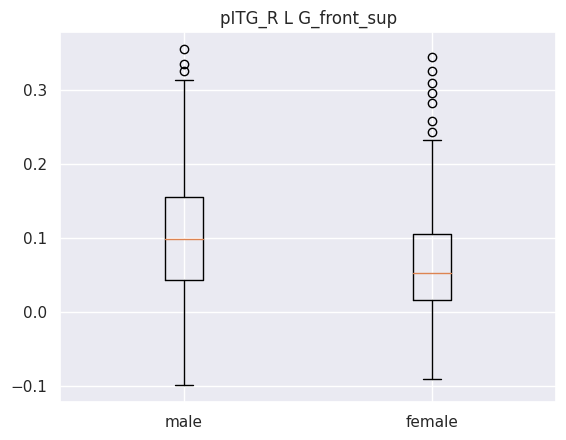

Ttest_indResult(statistic=5.343650897512694, pvalue=1.3257979942942627e-07)
male mean : 0.10204701447452472
female mean : 0.06652489050332226


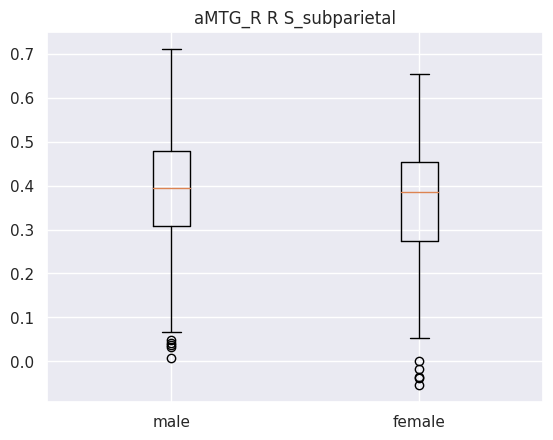

Ttest_indResult(statistic=1.8896304959307062, pvalue=0.059321818335763714)
male mean : 0.3831714017832699
female mean : 0.36253010012717607


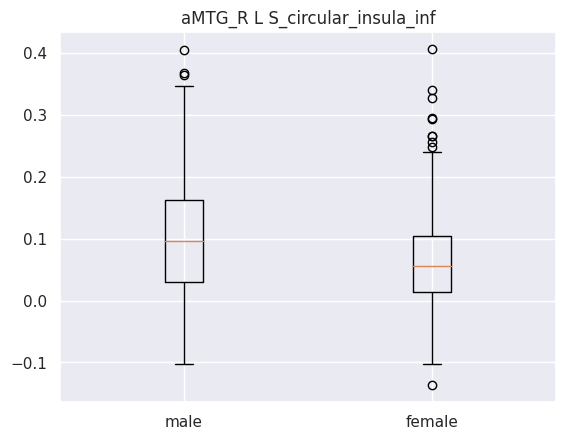

Ttest_indResult(statistic=5.519848416328338, pvalue=5.188050187200102e-08)
male mean : 0.10639979831471483
female mean : 0.06546545337565116
                                   Region       Men     Women       P value
0                  pITG_R - L S_calcarine  0.184810  0.155436  1.287314e-03
1    pITG_R - L S_oc-temp_med_and_Lingual  0.224477  0.195552  2.775747e-04
2     opIFG_R - R G_Ins_lg_and_S_cent_ins  0.262137  0.217900  5.378397e-07
3               opIFG_R - L S_postcentral  0.327808  0.278746  1.936948e-07
4       opIFG_R - L G_oc-temp_med-Parahip  0.069604  0.038605  8.054480e-10
5                  aMTG_R - R S_front_inf  0.095201  0.055367  3.868640e-05
6  planumtemp_R - R G_cingul-Post-ventral  0.263565  0.231567  1.360441e-02
7                  pITG_R - L G_front_sup  0.102047  0.066525  1.325798e-07
8                aMTG_R - R S_subparietal  0.383171  0.362530  5.932182e-02
9        aMTG_R - L S_circular_insula_inf  0.106400  0.065465  5.188050e-08


In [155]:
rois = ["opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_right)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

# Noise testing

In [156]:
study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/')
results_path_all_seed = study_dir / "results_2024" / "LinearSVC" / "seed-all_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"

moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_seed)

In [157]:
model_test = data_results["model"][random.randint(0, 10000)]
gender_test = np.asarray(df_boot["Gender"])
score, perm_score, p_val = permutation_test_score(model_test, x_correl, gender_test)

In [158]:
acc_iter = []
model_test = data_results["model"][random.randint(0, 10000)]
for i in range(0, 10000):
    gender_test = np.asarray(df_boot["Gender"])
    np.random.shuffle(gender_test)
    acc_rand = model_test.score(x_correl, gender_test)
    acc_iter.append(acc_rand)
    
acc_iter = np.asarray(acc_iter)

In [159]:
gender_test = np.asarray(df_boot["Gender"])
x_correl.size

667776

(0.4, 1.0)

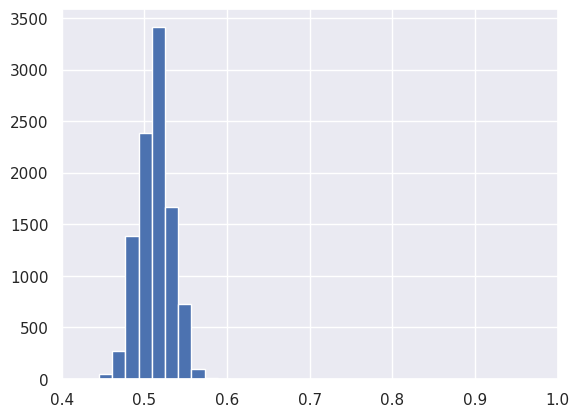

In [160]:
plt.hist(acc_iter)
plt.xlim([0.4, 1])

In [161]:
# accuracy should be around 0.50 (50%) if not it's a problem
acc_iter.mean()

0.5116209219858155

# Violin plot

In [ ]:
#1. make dataframe for the violin plot 
df = pd.DataFrame.from_dict(data, orient="index", columns=label["name"]).reset_index()
df["participant_id"] = df["index"].apply(lambda x: x[0])
df["seed"] = df["index"].apply(lambda x: x[1])
df["Gender"] = list(Final_df["Gender"]) * 8
df["Gender"] = df["Gender"].replace({0:"men", 1:"women"})

df_connectivity = df.melt(id_vars=["participant_id", "seed", "Gender"], value_vars=label["name"])
df_connectivity["pair"] = df_connectivity["seed"] + " with " + df_connectivity["name"]

df_temp_men = df_connectivity.loc[
    (df_connectivity["Gender"] == "men") &
    (df_connectivity["pair"] == "aMTG_L with L S_front_sup")
]  
df_temp_women = df_connectivity.loc[
    (df_connectivity["Gender"] == "women") &
    (df_connectivity["pair"] == "aMTG_L with L S_front_sup")
]
stats.ttest_ind(df_temp_men["value"], df_temp_women["value"])
print(df_temp_men["value"].mean())


# A changer selon les dix meilleures seeds
# list to make sure top 10 regions are in order 

top10 = ["aMTG_L with L S_front_sup",
         "aMTG_L with R G_pariet_inf-Angular",
         "pITG_L with R G_front_inf-Orbital",
         "aMTG_L with L G_and_S_transv_frontopol",
         "planumtemp_R with L S_interm_prim-Jensen", 
         "pITG_R with L G_oc-temp_lat-fusifor",
         "pITG_L with L G_cingul-Post-ventral",
         "opIFG_L with L Pole_occipital",
         "planumtemp_R with L S_calcarine", 
         "aMTG_R with L S_front_sup"]
         

df_temp = df_connectivity.loc[
    #(df_connectivity["seed"] == "opIFG_L") &
    (df_connectivity["pair"].isin(top10))
]  
df_temp["Sex"] = df_temp["Gender"]
df_temp["Functional Connectivity Values"] = df_temp["value"]
df_temp["Pair"] = df_temp["pair"]

# plt.figure(figsize=(20, 11.25))

sns.set_theme(context="poster")

v_plot = sns.violinplot(x="Pair", y="Functional Connectivity Values", hue="Sex", data=df_temp, split= True, bw=0.10,inner = None, palette="muted", order=top10)
# v_plot.set_xticks([0,1])
# v_plot.set_xticklabels(["aMTG_L\nL S_front_sup", "2"])
# v_plot

v_plot = sns.pointplot(x="Pair", y="Functional Connectivity Values", hue="Sex",
                    data=df_temp, dodge=0.2, join=False, palette=['white'], ax=v_plot, scale=0.5, order=top10, legend=False)

# changer les xticklabels selon les labels obtenues
# v_plot.set_xticks([0,1,2,3,4,5,6,7,8,9])
# v_plot.set_xticklabels(["aMTG_L\nL S_front_sup", 
#                     "aMTG_L\nR G_pariet_inf-Angular",
#                     "pITG_L\nR G_front_inf-Orbital", 
#                     "aMTG_L\nL G_and_S_transv_frontopol",
#                     "planumtemp_R\nL S_interm_prim-Jensen", 
#                     "pITG_R\nL G_oc-temp_lat-fusifor",
#                     "pITG_L\nL G_cingul-Post-ventral",
#                     "opIFG_L\nL Pole_occipital",
#                     "planumtemp_R\nL S_calcarine",
#                     "aMTG_R\nL S_front_sup"], rotation=30)


# fig = v_plot.get_figure()
# fig.set_size_inches(28.5, 15)
# plt.tight_layout()
# fig.savefig("violin_plot.png", dpi=300)